# Accelerating Cleantech Advancements through NLP-Powered Text Mining and Knowledge Extraction

Group: Marusa Storman, Vignesh Govindaraj, Pradip Ravichandran

## Stage 1: Enhanced Data Cleaning, Preprocessing, and Exploratory Analysis

### Data Collection

In [1]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
# import spacy
import string
import unidecode
import unicodedata

from collections import Counter
from langdetect import detect
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spellchecker import SpellChecker
from urllib.parse import urlparse, urlunparse
from wordcloud import WordCloud

# Set preferences
sns.set(color_codes=True)
sns.set_style("whitegrid")

# Download needed NLTK's resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pradip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# READ ALL FILES

# Read the JSON file
results_json = pd.read_json("Data/bq-results-20240124-055833-1706076079048.json", lines=True)

# Read the first CSV file
ct_media = pd.read_csv("Data/cleantech_media_dataset_v2_2024-02-23.csv")

# Read the second CSV file
ct_evaluation = pd.read_csv("Data/cleantech_rag_evaluation_data_2024-02-23.csv")


In [3]:
# This function will provide with more useful information:
def analyze_column(df, head=True, has_list=False):
    if head:
        print(df.head())
        print()

    info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Number of Entries': df.count(),
        'Missing/None Count': df.isna().sum()
    })
    
    if not has_list:
        info['Uniqueness'] = df.nunique()
   
    print(info)

print("Google Patent Dataset:")
analyze_column(results_json, has_list=True)

Google Patent Dataset:
  publication_number application_number country_code  \
0   US-2022239235-A1  US-202217717397-A           US   
1   US-2022239251-A1  US-202217580956-A           US   
2      EP-4033090-A1      EP-21152924-A           EP   
3      EP-4033090-A1      EP-21152924-A           EP   
4     US-11396827-B2  US-202117606042-A           US   

                                     title_localized  \
0  [{'text': 'Adaptable DC-AC Inverter Drive Syst...   
1  [{'text': 'System for providing the energy fro...   
2  [{'text': 'Verfahren zum steuern einer windene...   
3  [{'text': 'Verfahren zum steuern einer windene...   
4  [{'text': 'Control method for optimizing solar...   

                                  abstract_localized  publication_date  \
0  [{'text': 'Disclosed is an adaptable DC-AC inv...          20220728   
1  [{'text': 'In accordance with an example embod...          20220728   
2  [{'text': 'Verfahren zum Steuern einer Windene...          20220727   
3  [{'t

In [4]:
#### Flatts the nested JSON objects
def flat_data(df, column_name):
    flattened_dicts = []
    
    for index, row in df.iterrows():
        specific_column = row.get(column_name, [])  # Get the list of title_localized values
    
        # Check if specific_column is not empty
        if specific_column:
            # Iterate through each title_localized value
            for specific_column_value in specific_column:
                # Check if the value is a dictionary
                if isinstance(specific_column_value, dict):
                    # Flatten the title_localized JSON object
                    flattened_row = {f"{column_name}_{key}": value for key, value in specific_column_value.items() if value}
    
                    # Append the modified row to flattened_dicts
                    flattened_dicts.append({**row, **flattened_row})
        else:
            # Append the original row if title_localized is empty
            flattened_dicts.append(row)
    
    # Create a new DataFrame from flattened_dicts
    flatten_df = pd.DataFrame(flattened_dicts)
    flatten_df.drop(columns=[column_name], inplace=True)
    return flatten_df

results_json = flat_data(results_json, 'title_localized')
results_json = flat_data(results_json, 'abstract_localized')
results_json = flat_data(results_json, 'cpc')

analyze_column(results_json, has_list=True)

  publication_number application_number country_code  publication_date  \
0   US-2022239235-A1  US-202217717397-A           US          20220728   
1   US-2022239235-A1  US-202217717397-A           US          20220728   
2   US-2022239235-A1  US-202217717397-A           US          20220728   
3   US-2022239235-A1  US-202217717397-A           US          20220728   
4   US-2022239235-A1  US-202217717397-A           US          20220728   

  inventor                               title_localized_text  \
0       []  Adaptable DC-AC Inverter Drive System and Oper...   
1       []  Adaptable DC-AC Inverter Drive System and Oper...   
2       []  Adaptable DC-AC Inverter Drive System and Oper...   
3       []  Adaptable DC-AC Inverter Drive System and Oper...   
4       []  Adaptable DC-AC Inverter Drive System and Oper...   

  title_localized_language                            abstract_localized_text  \
0                       en  Disclosed is an adaptable DC-AC inverter syste...   
1 

In [5]:
def analyze_list_column(df, column_name, with_object=False):
    # Count the number of rows with empty lists
    empty_count = df[df[column_name].apply(lambda x: isinstance(x, list) and len(x) == 0)].shape[0]

    # Calculate the average length of non-empty lists
    non_empty_avg_length = df[df[column_name].apply(lambda x: isinstance(x, list) and len(x) > 0)][column_name].apply(len).mean()

    print("Number of rows with empty lists in '{}' column: {}".format(column_name, empty_count))

    if not pd.isnull(non_empty_avg_length):
        print("Average length of non-empty lists in '{}' column: {:.2f}".format(column_name, non_empty_avg_length))

    print()
   
analyze_list_column(results_json, 'inventor')


Number of rows with empty lists in 'inventor' column: 114405
Average length of non-empty lists in 'inventor' column: 3.52



In [6]:
print("Media Dataset:")
analyze_column(ct_media)
print()
print("Number of duplicate rows:", ct_media.duplicated().sum())
analyze_list_column(ct_media, 'content')

Media Dataset:
   Unnamed: 0                                              title        date  \
0        1280  Qatar to Slash Emissions as LNG Expansion Adva...  2021-01-13   
1        1281               India Launches Its First 700 MW PHWR  2021-01-15   
2        1283              New Chapter for US-China Energy Trade  2021-01-20   
3        1284  Japan: Slow Restarts Cast Doubt on 2030 Energy...  2021-01-22   
4        1285     NYC Pension Funds to Divest Fossil Fuel Shares  2021-01-25   

  author                                            content       domain  \
0    NaN  ["Qatar Petroleum ( QP) is targeting aggressiv...  energyintel   
1    NaN  ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...  energyintel   
2    NaN  ["New US President Joe Biden took office this ...  energyintel   
3    NaN  ["The slow pace of Japanese reactor restarts c...  energyintel   
4    NaN  ["Two of New York City's largest pension funds...  energyintel   

                                               

In [7]:
print("Media Evaluation Dataset:")
analyze_column(ct_evaluation)
print()
print("Number of duplicate rows:", ct_evaluation.duplicated().sum())

Media Evaluation Dataset:
   example_id  question_id                                           question  \
0           1            1  What is the innovation behind Leclanché's new ...   
1           2            2       What is the EU’s Green Deal Industrial Plan?   
2           3            2       What is the EU’s Green Deal Industrial Plan?   
3           4            3  What are the four focus areas of the EU's Gree...   
4           5            4  When did the cooperation between GM and Honda ...   

                                      relevant_chunk  \
0  Leclanché said it has developed an environment...   
1  The Green Deal Industrial Plan is a bid by the...   
2  The European counterpart to the US Inflation R...   
3  The new plan is fundamentally focused on four ...   
4  What caught our eye was a new hookup between G...   

                                         article_url  
0  https://www.sgvoice.net/strategy/technology/23...  
1  https://www.sgvoice.net/policy/25396/

### JSON text preprocessing and EDA

In [8]:
results_json.head()
# Based on the output, we have to change the date into readable form, preprocess publication and application number(not sure about that?), preprocess title and abstract text, address the missing in inventor and drop the cpc column (for now)

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,cpc_inventive,cpc_first
0,US-2022239235-A1,US-202217717397-A,US,20220728,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02M7/5395,True,NaN
1,US-2022239235-A1,US-202217717397-A,US,20220728,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J3/32,NaN,NaN
2,US-2022239235-A1,US-202217717397-A,US,20220728,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02M1/32,True,NaN
3,US-2022239235-A1,US-202217717397-A,US,20220728,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J1/10,True,NaN
4,US-2022239235-A1,US-202217717397-A,US,20220728,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en,H02J3/381,True,NaN


#### Change date format

In [9]:
# Change JSON date format
results_json['publication_date'] = pd.to_datetime(results_json['publication_date'], format='%Y%m%d')

#### Check and drop duplicates

In [10]:
# Calculate the number of duplicate rows, excluding 'inventor'
columns_to_check = [col for col in results_json.columns if col != 'inventor']
duplicate_rows = results_json.duplicated(subset=columns_to_check, keep='first').sum()

# Calculate the percentage of duplicate rows
percentage_duplicates = (duplicate_rows / len(results_json)) * 100

print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")
#68.2% of duplicate rows!!!

Percentage of duplicate rows: 68.27%


In [11]:
# Display some duplicate rows to inspect them
duplicates_to_inspect = results_json[results_json.duplicated(subset=columns_to_check, keep=False)]
duplicates_to_inspect.head()
##everything expect cpc_code and cpc_first seems the same! We need to further inspect to analyze the differences and decide how to handle duplicated data

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,cpc_code,cpc_inventive,cpc_first
12,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276,True,True
13,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296,True,NaN
14,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/028,True,NaN
15,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0276,True,True
16,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de,F03D7/0296,True,NaN


In [12]:
# Group by fields that should be identical if the entries are truly duplicates
grouped = results_json.groupby([
    'publication_number', 'application_number', 'country_code',
    'publication_date', 'title_localized_text', 'title_localized_language',
    'abstract_localized_text', 'abstract_localized_language'
])

# Analyze the variation within each group for 'cpc_code'
variation = grouped['cpc_code'].nunique()

# Display groups with more than one unique 'cpc_code' to inspect variations
print(variation[variation > 1])

publication_number  application_number  country_code  publication_date  title_localized_text                                                                                                  title_localized_language  abstract_localized_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [13]:
# Columns to group by, excluding 'cpc_code' and 'inventor'
group_columns = [col for col in results_json.columns if col not in ('cpc_code', 'inventor')]

# Group by these columns and aggregate 'cpc_code' to see unique entries
grouped = results_json.groupby(group_columns)['cpc_code'].agg(['unique', 'nunique']).reset_index()

# Sort the DataFrame based on the number of unique CPC codes to see the groups with the most variety
grouped_sorted = grouped.sort_values(by='nunique', ascending=False)

# Display the top entries with the most variety in 'cpc_code'
print(grouped_sorted.head(10))


     publication_number application_number country_code publication_date  \
790      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
791      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
788      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
789      CN-110945234-B  CN-201980002226-A           CN       2021-12-14   
4623     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
4622     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
4621     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
4620     CN-113719426-A  CN-202110566708-A           CN       2021-11-30   
9325     CN-114057781-A  CN-202110871098-A           CN       2022-02-18   
176      CN-106902876-B  CN-201710129107-A           CN       2022-04-15   

                                   title_localized_text  \
790                                             海上能源岛装置   
791                                          

In [14]:
# Define columns that represent the text data and their translations
text_columns = ['title_localized_text', 'abstract_localized_text', 'title_localized_language', 'abstract_localized_language']

# Group by these text columns and aggregate 'cpc_code' to see unique entries
grouped = results_json.groupby(text_columns)['cpc_code'].agg(['unique', 'nunique']).reset_index()

# Add a new column to see how many different CPC codes there are per group
grouped['cpc_code_count'] = grouped['unique'].apply(len)

# Sort the DataFrame by the number of unique CPC codes to highlight entries with the most variation
grouped_sorted = grouped.sort_values(by='cpc_code_count', ascending=False)

# Display the top entries with the most CPC code variations
grouped_sorted.head(10)

,title_localized_text,abstract_localized_text,title_localized_language,abstract_localized_language,unique,nunique,cpc_code_count
22111,Solar powered display assemblies,La présente invention concerne des ensembles d...,en,fr,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,45
22659,Solarbetriebene anzeigeanordnungen,Solar powered display assemblies and systems a...,de,en,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,45
6658,Ensembles d&#39;affichage à énergie solaire,Solar powered display assemblies and systems a...,fr,en,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,45
6657,Ensembles d&#39;affichage à énergie solaire,La présente invention concerne des ensembles d...,fr,fr,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,45
22658,Solarbetriebene anzeigeanordnungen,La présente invention concerne des ensembles d...,de,fr,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,45
22117,Solar powered vehicle topper unit,A solar powered vehicle topper unit and system...,en,en,"[H02S20/30, H02S20/23, Y02E70/30, G09F15/0037,...",45,45
22116,Solar powered vehicle topper unit,A solar powered vehicle topper unit and system...,en,en,"[Y02T10/70, Y02E70/30, Y02E10/56, Y02B10/10, H...",45,45
22115,Solar powered vehicle mounted display,Systems and methods for solar powered vehicle ...,en,en,"[Y02T10/70, Y02E70/30, Y02E10/56, Y02B10/10, H...",45,45
22114,Solar powered vehicle mounted display,Systems and methods for providing solar-genera...,en,en,"[G09F15/0037, G09F9/30, H02S20/23, Y02T10/70, ...",45,45
22112,Solar powered display assemblies,Solar powered display assemblies and systems a...,en,en,"[B60Y2400/60, E04H1/1211, B60Y2300/91, H02S20/...",45,45


there are entries with very similar or identical text descriptions across different languages, and they're associated with a large number of unique cpc_code values (45 in this case). This could suggest that despite the textual content being translated and appearing the same across different languages, the classifications (as represented by cpc_code) are highly varied.

In [15]:
# Group by cpc_code to see related text entries and calculate aggregates
grouped_by_cpc = results_json.groupby('cpc_code').agg({
    'title_localized_text': lambda texts: set(texts),
    'abstract_localized_text': lambda texts: set(texts),
    'title_localized_language': lambda x: x.nunique(),  # Get number of unique languages for titles
    'abstract_localized_language': lambda x: x.nunique()  # Get number of unique languages for abstracts
}).reset_index()

# Add a column for counting occurrences of each cpc_code, already implicitly done by the size of the group
grouped_by_cpc['count'] = grouped_by_cpc['title_localized_text'].apply(len)

# Sort by the number of unique entries to see which CPC codes have the most variation
grouped_by_cpc_sorted = grouped_by_cpc.sort_values(by='count', ascending=False)
grouped_by_cpc_sorted.head()
## Dataframe with the CPC codes alongside corresponding sets of titles and abstracts in various languages, as 
#well as counts of how many entries are grouped under each CPC code

,cpc_code,title_localized_text,abstract_localized_text,title_localized_language,abstract_localized_language,count
6938,Y02E10/50,{Preparation method of solar cell and solar ce...,{The invention relates to an energy-saving and...,12,11,4855
6951,Y02E10/72,{Wind driven generator with generator landing ...,{本发明提供一种立体发电系统，包括多个第一风力发电机，相邻的第一风力发电机具有第一相邻水平距...,11,10,1457
6982,Y02E70/30,{Flywheel and molten salt hybrid energy storag...,{A charging station for electric vehicles incl...,8,6,1376
6937,Y02E10/47,"{一种太阳能光伏组件, 一种光伏热水器, Système et procédé de déc...",{The utility model provides a solar energy tim...,6,6,1294
6934,Y02E10/40,"{一种存储太阳能的储热管, 一种便于对内胆进行清理的智能数字化太阳能水箱, 太阳能与空气源热...",{The utility model relates to the technical fi...,7,6,855


In [16]:
# Drop the 'cpc' columns
results_json.drop(['cpc_code'], axis=1, inplace=True)
results_json.drop(['cpc_inventive'], axis=1, inplace=True)
results_json.drop(['cpc_first'], axis=1, inplace=True)

In [17]:
### I guess we decided to drop the duplicates for now but we can always inspect and correct later if needed
# Columns to consider when checking for duplicates
columns_to_check = [col for col in results_json.columns if col != 'inventor']

# Find duplicate rows, except for the 'inventor' column
duplicates = results_json.duplicated(subset=columns_to_check, keep='first')

# Count the duplicates
duplicate_count = duplicates.sum()
print(f"Number of duplicate rows (excluding 'inventor'): {duplicate_count}")

# Drop the duplicates if needed
if duplicate_count > 0:
    results_json = results_json[~duplicates].reset_index(drop=True)

# extra code to make sure both calculate the same amount of duplicates 334190, and 0 after dropping
results_json.duplicated(subset=[col for col in results_json.columns if col != 'inventor']).sum()

Number of duplicate rows (excluding 'inventor'): 436159


0

In [18]:
results_json.head(10)

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,[],Adaptable DC-AC Inverter Drive System and Oper...,en,Disclosed is an adaptable DC-AC inverter syste...,en
1,US-2022239251-A1,US-202217580956-A,US,2022-07-28,[],System for providing the energy from a single ...,en,"In accordance with an example embodiment, a so...",en
2,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de
3,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Verfahren zum steuern einer windenergieanlage,de,Verfahren zum Steuern einer Windenergieanlage ...,de
4,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Method for controlling a wind energy system,en,Verfahren zum Steuern einer Windenergieanlage ...,de
5,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Method for controlling a wind energy system,en,Verfahren zum Steuern einer Windenergieanlage ...,de
6,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Procédé de commande d&#39;une éolienne,fr,Verfahren zum Steuern einer Windenergieanlage ...,de
7,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, von Aswege, Enno, Gerke Funcke,...",Procédé de commande d&#39;une éolienne,fr,Verfahren zum Steuern einer Windenergieanlage ...,de
8,US-11396827-B2,US-202117606042-A,US,2022-07-26,[],Control method for optimizing solar-to-power e...,en,A control method for optimizing a solar-to-pow...,en
9,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,[],Low-carbon running saline wastewater treatment...,en,本发明公开了一种应用太阳能和环路热管的低碳运行含盐废水处理系统及方法，属于含盐废水低碳处理领...,zh


#### Inspect "inventor" column

In [19]:
# Calculate the percentage of non-empty entries in 'inventor'
non_empty_inventors = results_json['inventor'].apply(bool).mean() * 100
print(f"Percentage of non-empty 'inventor' entries: {non_empty_inventors}%")


Percentage of non-empty 'inventor' entries: 62.74028092943008%


In [20]:
# Standardize the names in the 'inventor' column and handle missing data
results_json['inventor'] = results_json['inventor'].apply(lambda x: [name.strip().title() for name in x] if x else None)

# Create a new column for the count of inventors
results_json['num_inventors'] = results_json['inventor'].apply(lambda x: len(x) if x else 0)

# Create a binary indicator for multiple inventors
results_json['multiple_inventors'] = results_json['num_inventors'].apply(lambda x: 1 if x > 1 else 0)

# Check the results
print(results_json[['inventor', 'num_inventors', 'multiple_inventors']].head())

# Analyze the distribution of the number of inventors
print("Distribution of number of inventors:")
print(results_json['num_inventors'].value_counts())

                                            inventor  num_inventors  \
0                                               None              0   
1                                               None              0   
2  [Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...              3   
3  [Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...              3   
4  [Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...              3   

   multiple_inventors  
0                   0  
1                   0  
2                   1  
3                   1  
4                   1  
Distribution of number of inventors:
num_inventors
0     19868
1     11824
2      4571
3      4445
4      3088
5      2835
6      2018
7      1412
8       961
9       585
10      506
11      274
12      235
13      166
15      149
14      120
16       53
18       48
17       44
20       36
21       33
19       28
25        8
22        4
24        4
38        4
29        4
Name: count, dtype: int64


In [22]:
# Define a function to remove the prefix and suffix
def remove_prefix_suffix(text):
    # Remove the country code prefix
    text = re.sub(r'^[A-Za-z]+-', '', text)
    # Remove any suffix that starts with a dash after the numeric sequence
    text = re.sub(r'-.+$', '', text)
    return text

# Apply the function to the publication and application number columns
#results_json['publication_number'] = results_json['publication_number'].apply(remove_prefix_suffix)
#results_json['application_number'] = results_json['application_number'].apply(remove_prefix_suffix)

# Display the DataFrame to confirm the changes
#print(results_json[['publication_number', 'application_number']].head())

### Text cleaning 

In [23]:
# Check for null values in specific columns (adjust column names as per your DataFrame)
print(results_json['abstract_localized_text'].isnull().sum())
print(results_json['title_localized_text'].isnull().sum())

0
0


In [24]:
def unique_characters(data, column_name):
    unique_chars = set()
    for item in data[column_name].dropna():
        unique_chars.update(item)
    return sorted(unique_chars)

# Get unique characters from both columns
abstract_unique_chars = unique_characters(results_json, 'abstract_localized_text')
title_unique_chars = unique_characters(results_json, 'title_localized_text')

print("Unique characters in abstracts:", abstract_unique_chars)
print("Unique characters in titles:", title_unique_chars)

Unique characters in abstracts: ['\n', ' ', '#', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x92', '\xa0', '«', '\xad', '°', '±', '²', '·', '»', 'À', 'É', 'Î', 'Ö', '×', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ñ', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ā', 'ă', 'ą', 'ć', 'č', 'đ', 'ē', 'ė', 'ę', 'ģ', 'ī', 'Į', 'į', 'ķ', 'ł', 'ń', 'ņ', 'œ', 'ś', 'ş', 'Š', 'š', 'ţ', 'ū', 'ų', 'ź', 'ż', 'ž', 'ΐ', 'Δ', 'Η', 'Ο', 'Σ', 'Τ', 'Φ', 'ά', 'έ', 'ή', 'ί', 'α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω', 'ϊ', 'ό', '

In [25]:
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lower case
    text = text.lower()
    # Remove HTML entities
    text = re.sub(r'&[a-zA-Z]+;', '', text)
    # Remove unwanted characters, but preserve hyphens within words
    text = re.sub(r'[^a-z\s\.,;:\'"\(\)\[\]{}\u4e00-\u9fff-]', '', text)
    # Clean up any stray hyphens that do not form part of a hyphenated word
    text = re.sub(r'\b-\b', ' ', text)
     # Remove specific unwanted characters and all punctuation except for internal hyphens
    text = re.sub(r'[():;,\[\]{}]', '', text)  # Removes (), [], {}, :, ;, and commas
    # Clean up any stray hyphens that do not form part of a hyphenated word
    text = re.sub(r'\b-\b', ' ', text)
    # Remove multiple spaces and trim
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    # Normalize Chinese and other special characters by removing excess punctuation while keeping these characters
    text = re.sub(r'[\s]+', ' ', text).strip()
    return text

# Apply cleaning function to both columns
results_json['abstract_localized_text'] = results_json['abstract_localized_text'].apply(clean_text)
results_json['title_localized_text'] = results_json['title_localized_text'].apply(clean_text)

# Print cleaned text for inspection
print(results_json[['abstract_localized_text', 'title_localized_text']].head())


                             abstract_localized_text  \
0  disclosed is an adaptable dc ac inverter syste...   
1  in accordance with an example embodiment a sol...   
2  verfahren zum steuern einer windenergieanlage ...   
3  verfahren zum steuern einer windenergieanlage ...   
4  verfahren zum steuern einer windenergieanlage ...   

                                title_localized_text  
0  adaptable dc ac inverter drive system and oper...  
1  system for providing the energy from a single ...  
2      verfahren zum steuern einer windenergieanlage  
3      verfahren zum steuern einer windenergieanlage  
4        method for controlling a wind energy system  


In [26]:
def clean_text(text):
    # Normalize text to ASCII
    text = unidecode.unidecode(text) ##double check why different characters for languages get deleted with this code, it should not
    # Convert text to lowercase
    text = text.lower()
    # Retain alphanumeric characters including those from provided languages, spaces, and select punctuation
    text = re.sub(r'[^\w\s\u4e00-\u9fff\u3400-\u4dbf\uf900-\ufaff\U00020000-\U0002a6df\U0002a700-\U0002ebef\U00030000-\U0003134f\U00031350-\U000323af\u3040-\u309F\u30A0-\u30FF\uAC00-\uD7AF\u0400-\u04FF\u0100-\u024F\u1E00-\u1EFF\u0370-\u03FF\u1F00-\u1FFF\u2C80-\u2CFF\u0100-\u017F\u0400-\u04FF]',
            '', text)
    return text


# Apply cleaning function to both columns
results_json['abstract_localized_text'] = results_json['abstract_localized_text'].apply(clean_text)
results_json['title_localized_text'] = results_json['title_localized_text'].apply(clean_text)

# Print cleaned text for inspection
print(results_json[['abstract_localized_text', 'title_localized_text']].head())


                             abstract_localized_text  \
0  disclosed is an adaptable dc ac inverter syste...   
1  in accordance with an example embodiment a sol...   
2  verfahren zum steuern einer windenergieanlage ...   
3  verfahren zum steuern einer windenergieanlage ...   
4  verfahren zum steuern einer windenergieanlage ...   

                                title_localized_text  
0  adaptable dc ac inverter drive system and oper...  
1  system for providing the energy from a single ...  
2      verfahren zum steuern einer windenergieanlage  
3      verfahren zum steuern einer windenergieanlage  
4        method for controlling a wind energy system  


In [27]:
##inspect special characters again 
def get_unique_characters(df, column_name):
    unique_chars = set()
    for text in df[column_name]:
        unique_chars.update(text)
    return unique_chars

# Get unique characters from the cleaned abstract and title text
unique_chars_abstract = get_unique_characters(results_json, 'abstract_localized_text')
unique_chars_title = get_unique_characters(results_json, 'title_localized_text')

print("Unique characters in abstracts:", sorted(unique_chars_abstract))
print("Unique characters in titles:", sorted(unique_chars_title))


Unique characters in abstracts: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unique characters in titles: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [28]:
print(results_json.head(10))

  publication_number application_number country_code publication_date  \
0   US-2022239235-A1  US-202217717397-A           US       2022-07-28   
1   US-2022239251-A1  US-202217580956-A           US       2022-07-28   
2      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
3      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
4      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
5      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
6      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
7      EP-4033090-A1      EP-21152924-A           EP       2022-07-27   
8     US-11396827-B2  US-202117606042-A           US       2022-07-26   
9     CN-114772674-A  CN-202210500131-A           CN       2022-07-22   

                                            inventor  \
0                                               None   
1                                               None   
2  [Schaper, Ulf, Von Aswege

In [29]:
# Tokenizing text
results_json['abstract_tokens'] = results_json['abstract_localized_text'].apply(word_tokenize)
results_json['title_tokens'] = results_json['title_localized_text'].apply(word_tokenize)

# Counting tokens
results_json['abstract_token_count'] = results_json['abstract_tokens'].apply(len)
results_json['title_token_count'] = results_json['title_tokens'].apply(len)

# Print to verify
print("Token counts in abstracts and titles:")
print(results_json[['abstract_localized_text', 'abstract_token_count', 'title_localized_text', 'title_token_count']].head())


Token counts in abstracts and titles:
                             abstract_localized_text  abstract_token_count  \
0  disclosed is an adaptable dc ac inverter syste...                    67   
1  in accordance with an example embodiment a sol...                    92   
2  verfahren zum steuern einer windenergieanlage ...                   208   
3  verfahren zum steuern einer windenergieanlage ...                   207   
4  verfahren zum steuern einer windenergieanlage ...                   208   

                                title_localized_text  title_token_count  
0  adaptable dc ac inverter drive system and oper...                  8  
1  system for providing the energy from a single ...                 18  
2      verfahren zum steuern einer windenergieanlage                  5  
3      verfahren zum steuern einer windenergieanlage                  5  
4        method for controlling a wind energy system                  7  


In [30]:
# Determine minimum and maximum token counts across the dataset
min_abstract_tokens = results_json['abstract_token_count'].min()
max_abstract_tokens = results_json['abstract_token_count'].max()
min_title_tokens = results_json['title_token_count'].min()
max_title_tokens = results_json['title_token_count'].max()

print("\nMinimum and maximum token counts:")
print(f"Abstracts - Min: {min_abstract_tokens}, Max: {max_abstract_tokens}")
print(f"Titles - Min: {min_title_tokens}, Max: {max_title_tokens}")


Minimum and maximum token counts:
Abstracts - Min: 0, Max: 500
Titles - Min: 0, Max: 55


#### Handle nonsensical and empty abstract and title text

In [31]:
# Set a threshold for minimum token count
min_token_threshold = 4 # Adjust as needed

# Filter English language entries
english_entries = results_json[(results_json['title_localized_language'] == 'en') & 
                               (results_json['abstract_localized_language'] == 'en')]

# Filter entries in the DataFrame with token count lower than the threshold within the English entries
low_abstract_token_entries = english_entries[english_entries['abstract_token_count'] < min_token_threshold]
low_title_token_entries = english_entries[english_entries['title_token_count'] < min_token_threshold]

# Examine the suspicious entries
print("Entries with low abstract token count:")
print(low_abstract_token_entries[['abstract_localized_text', 'abstract_token_count']])

print("\nEntries with low title token count:")
print(low_title_token_entries[['title_localized_text', 'title_token_count']])

# Based on examination, you can then decide to remove or correct the entries
# For example, to remove entries with low abstract token count from the original DataFrame:
#results_json = results_json[results_json['abstract_token_count'] >= min_token_threshold]

# Do the same for the title text if necessary
#results_json = results_json[results_json['title_token_count'] >= min_token_threshold]

# Based on examination, you can then decide to remove or correct the entries
# To remove entries with low abstract token count from the English entries
english_entries = english_entries[english_entries['abstract_token_count'] >= min_token_threshold]

# Do the same for the title text if necessary
english_entries = english_entries[english_entries['title_token_count'] >= min_token_threshold]

# Optionally, you might want to merge these filtered English entries back into the main DataFrame if needed
# This would replace the English entries in the main DataFrame with the filtered ones
results_json.update(english_entries)


Entries with low abstract token count:
Empty DataFrame
Columns: [abstract_localized_text, abstract_token_count]
Index: []

Entries with low title token count:
                     title_localized_text  title_token_count
437                   photovoltaic module                  2
533             intelligent bird repeller                  3
588                 wind power automobile                  3
610                solar refrigerator car                  3
653              wind energy installation                  3
...                                   ...                ...
52892                    solar stair lamp                  3
53158            solar charging structure                  3
53240  afforestation irrigation equipment                  3
53251               river dredging device                  3
53296                  assembled bathroom                  2

[547 rows x 2 columns]


In [32]:
# Print random samples from the English entries to inspect the data
english_entries[['abstract_localized_text', 'abstract_token_count', 'title_localized_text', 'title_token_count']].sample(5)


,abstract_localized_text,abstract_token_count,title_localized_text,title_token_count
40576,the utility model discloses a visible light ca...,198,visible light catalysis sewage treatment device,6
3988,the invention discloses a divergent type liqui...,211,agricultural is spouted medicine unmanned aeri...,17
22912,the utility model discloses a high efficiency ...,200,efficient wind energy conversion generator set,6
21264,the utility model provides a road traffic poll...,140,road traffic pollution early warning device ba...,11
23149,the utility model discloses a tea and tea dust...,233,tealeaves and tea dust separator,5


In [33]:
# Print the number of rows before filtering
print("Number of rows before filtering:", results_json.shape[0])

# Remove entries with zero tokens in abstract_text and title_text
filtered_results_json = results_json[(results_json['abstract_token_count'] > 0) & (results_json['title_token_count'] > 0)]

# Print the number of rows after filtering
print("Number of rows after filtering:", filtered_results_json.shape[0])

# Check the minimum token count in both columns
min_abstract_tokens = filtered_results_json['abstract_token_count'].min()
min_title_tokens = filtered_results_json['title_token_count'].min()

print("Minimum abstract token count:", min_abstract_tokens)
print("Minimum title token count:", min_title_tokens)


Number of rows before filtering: 53323
Number of rows after filtering: 53061
Minimum abstract token count: 1
Minimum title token count: 1


### Detect languages 

In [34]:
##old code

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return "error"  # Returns "error" if the language detection fails

# Apply language detection to abstracts and titles
# results_json['abstract_language'] = results_json['abstract_localized_text'].apply(detect_language)
# results_json['title_language'] = results_json['title_localized_text'].apply(detect_language)

# Print to verify
# print(results_json[['abstract_localized_text', 'abstract_language', 'text_localized_language', 'title_localized_text', 'title_language', 'title_localized_language']].head(20))
#some abstract and title text are nonsensical and empty, so I will address this to be able to receive correct language detection

In [35]:
results_json.head(10)

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,num_inventors,multiple_inventors,abstract_tokens,title_tokens,abstract_token_count,title_token_count
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,None,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,0,0,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8
1,US-2022239251-A1,US-202217580956-A,US,2022-07-28,None,system for providing the energy from a single ...,en,in accordance with an example embodiment a sol...,en,0,0,"[in, accordance, with, an, example, embodiment...","[system, for, providing, the, energy, from, a,...",92,18
2,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",verfahren zum steuern einer windenergieanlage,de,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[verfahren, zum, steuern, einer, windenergiean...",208,5
3,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",verfahren zum steuern einer windenergieanlage,de,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[verfahren, zum, steuern, einer, windenergiean...",207,5
4,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
5,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",207,7
6,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",procd de commande dune olienne,fr,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[procd, de, commande, dune, olienne]",208,5
7,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",procd de commande dune olienne,fr,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[procd, de, commande, dune, olienne]",207,5
8,US-11396827-B2,US-202117606042-A,US,2022-07-26,None,control method for optimizing solar to power e...,en,a control method for optimizing a solar to pow...,en,0,0,"[a, control, method, for, optimizing, a, solar...","[control, method, for, optimizing, solar, to, ...",166,20
9,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,None,low carbon running saline wastewater treatment...,en,ben fa ming gong kai liao yi chong ying yong t...,zh,0,0,"[ben, fa, ming, gong, kai, liao, yi, chong, yi...","[low, carbon, running, saline, wastewater, tre...",281,16


In [36]:
## Language detection in dataset
results_json.abstract_localized_language.unique()


array(['en', 'de', 'zh', 'ko', 'fr', 'ru', 'es', 'ro', 'lv', 'pl', 'ar',
       'sr', 'ja', 'hr', 'fi', 'el', 'pt', 'lt'], dtype=object)

In [37]:
# Check the distribution of languages in both abstracts and titles
abstract_lang_distribution = results_json['abstract_localized_language'].value_counts().reset_index()
abstract_lang_distribution.columns = ['language', 'text_count']

title_lang_distribution = results_json['title_localized_language'].value_counts().reset_index()
title_lang_distribution.columns = ['language', 'title_count']

# Merge the distributions into one DataFrame
merged_lang_distribution = pd.merge(abstract_lang_distribution, title_lang_distribution, on='language', how='outer').fillna(0)
merged_lang_distribution.sort_values(by='text_count', ascending=False, inplace=True)

# Display the merged language distributions
merged_lang_distribution


,language,text_count,title_count
3,en,26658.0,26618
19,zh,25673.0,25674
6,fr,572.0,590
10,ko,116.0,70
16,ru,90.0,113
1,de,87.0,142
9,ja,44.0,33
15,ro,24.0,24
4,es,17.0,17
0,ar,9.0,10


In [38]:
#Inspect mismatching languages for abstract and title
mismatched_language_count = results_json[results_json['abstract_localized_language'] != results_json['title_localized_language']]
mismatched_language_count.head(20)

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,num_inventors,multiple_inventors,abstract_tokens,title_tokens,abstract_token_count,title_token_count
4,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7
5,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",207,7
6,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",procd de commande dune olienne,fr,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[procd, de, commande, dune, olienne]",208,5
7,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",procd de commande dune olienne,fr,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[procd, de, commande, dune, olienne]",207,5
9,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,None,low carbon running saline wastewater treatment...,en,ben fa ming gong kai liao yi chong ying yong t...,zh,0,0,"[ben, fa, ming, gong, kai, liao, yi, chong, yi...","[low, carbon, running, saline, wastewater, tre...",281,16
12,CN-114772674-A,CN-202210500131-A,CN,2022-07-22,None,yi chong ying yong tai yang neng he huan lu re...,zh,the invention discloses a system and a method ...,en,0,0,"[the, invention, discloses, a, system, and, a,...","[yi, chong, ying, yong, tai, yang, neng, he, h...",238,28
13,CN-217026795-U,CN-202220668705-U,CN,2022-07-22,None,water ecological remediation device convenient...,en,ben shi yong xin xing gong kai liao yi chong b...,zh,0,0,"[ben, shi, yong, xin, xing, gong, kai, liao, y...","[water, ecological, remediation, device, conve...",267,8
16,CN-217026795-U,CN-202220668705-U,CN,2022-07-22,None,yi chong bian yu diao jie gao du de shui sheng...,zh,the utility model discloses a water ecological...,en,0,0,"[the, utility, model, discloses, a, water, eco...","[yi, chong, bian, yu, diao, jie, gao, du, de, ...",252,16
18,CN-114777546-A,CN-202210702520-A,CN,2022-07-22,None,cold and hot medium energy storage hot water a...,en,ben fa ming she ji chu neng ji zhu ling yu you...,zh,0,0,"[ben, fa, ming, she, ji, chu, neng, ji, zhu, l...","[cold, and, hot, medium, energy, storage, hot,...",275,17
19,CN-114777546-A,CN-202210702520-A,CN,2022-07-22,None,yi chong tai yang neng guang dian yong de leng...,zh,the invention relates to the technical field o...,en,0,0,"[the, invention, relates, to, the, technical, ...","[yi, chong, tai, yang, neng, guang, dian, yong...",72,23


In [39]:
mismatched_language_count = results_json[results_json['abstract_localized_language'] != results_json['title_localized_language']].shape[0]
print(f"Number of rows with mismatched languages: {mismatched_language_count}")

Number of rows with mismatched languages: 26705


#### Co-occurances analysation

In [40]:
# Function to calculate co-occurrences
def calculate_cooccurrences(data, column):
    # Define a count vectorizer
    count_vectorizer = CountVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words='english',
        binary=True
    )

    # Transform the text into binary flags
    counts = count_vectorizer.fit_transform(data[column])

    # Get the names of each column
    ngrams = count_vectorizer.get_feature_names_out()

    # Compute the product to get a co-occurrence matrix
    cooccurs = (counts.T * counts)

    # Fill the diagonal with zeros
    cooccurs.setdiag(0)

    # Convert to a dense format and make a DataFrame
    cooccurs_df = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
    
    return cooccurs_df

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_abstract = calculate_cooccurrences(results_json, 'abstract_localized_language')

# Calculate co-occurrences for the 'title_text' column
cooccurs_title = calculate_cooccurrences(results_json, 'title_localized_language')

# Display the co-occurrence DataFrames
print("Co-occurrences in abstracts:")
print(cooccurs_abstract.head())

print("\nCo-occurrences in titles:")
print(cooccurs_title.head())

Co-occurrences in abstracts:
    en  fr  zh
en   0   0   0
fr   0   0   0
zh   0   0   0

Co-occurrences in titles:
    en  fr  zh
en   0   0   0
fr   0   0   0
zh   0   0   0


#### Worldcloud

In [41]:
# WORLDCLOUD for abstract
all_abstract = results_json['abstract_localized_language']

In [42]:
# Concatenate strings in the Series/Index with cat() function to have all reviews as a string.
all_abstract.str.cat()

'enendedededededeenzhenzhenzhenzhenenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhzhenzhenenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhzhenzhenenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenenzhenzhenzhenzhenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhenenzhenzhzhenzhenenzhenzhenzhenzhenzhenzhenzhenzhenzhenzhzhenzhenzhenzhenzhenzhenenzhenzhenzhenzhzhenzhenenzhenzhenzhenzhenzhenzhzhenzhenenzhenzhzhenzhenzhenzhenzhenzhenzhenz

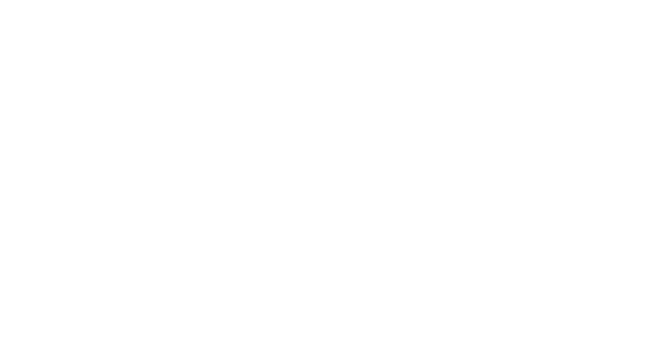

In [43]:
# Visualize
wordcloud = WordCloud(width = 800, height = 400,
                background_color ='white',
                min_font_size = 5).generate(all_abstract.str.cat())

# plot the WordCloud image
#plt.figure(figsize = (10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

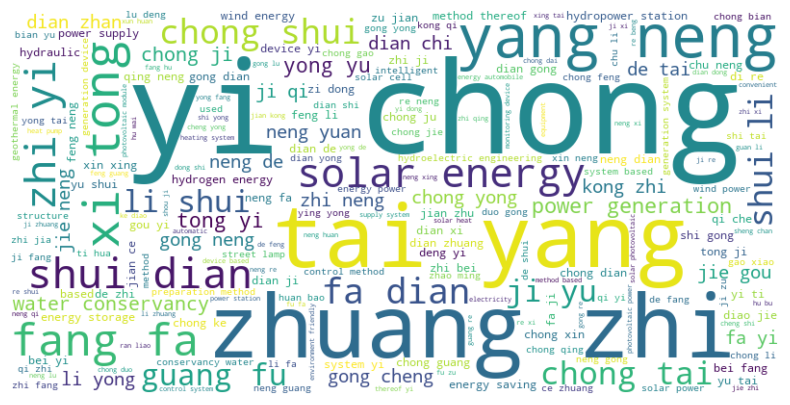

In [44]:
# WORLDCLOUD for title 
# Combine all abstracts into one large text
all_title = ' '.join(results_json['title_localized_text'].dropna())

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_title)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

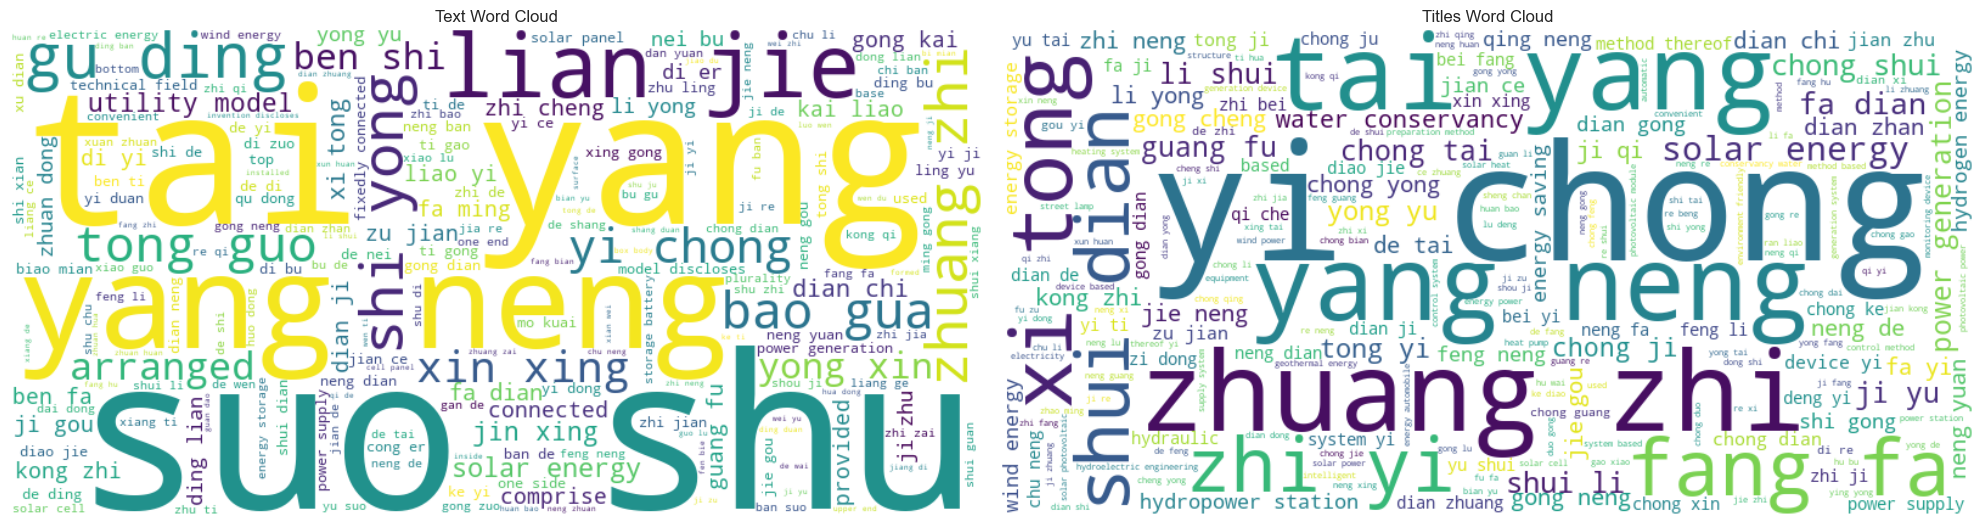

In [45]:
# Assuming 'results_json' is your DataFrame and it's already loaded

# Combine texts from abstracts and titles into separate strings
abstract_text = ' '.join(results_json['abstract_localized_text'].tolist())
title_text = ' '.join(results_json['title_localized_text'].tolist())

# Create word cloud objects
abstract_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstract_text)
title_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

# Setup matplotlib figures
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the word clouds
axes[0].imshow(abstract_wordcloud, interpolation='bilinear')
axes[0].set_title('Text Word Cloud')
axes[0].axis('off')  # Hide the axes for abstract word cloud

axes[1].imshow(title_wordcloud, interpolation='bilinear')
axes[1].set_title('Titles Word Cloud')
axes[1].axis('off')  # Hide the axes for title word cloud

plt.tight_layout()
plt.show()


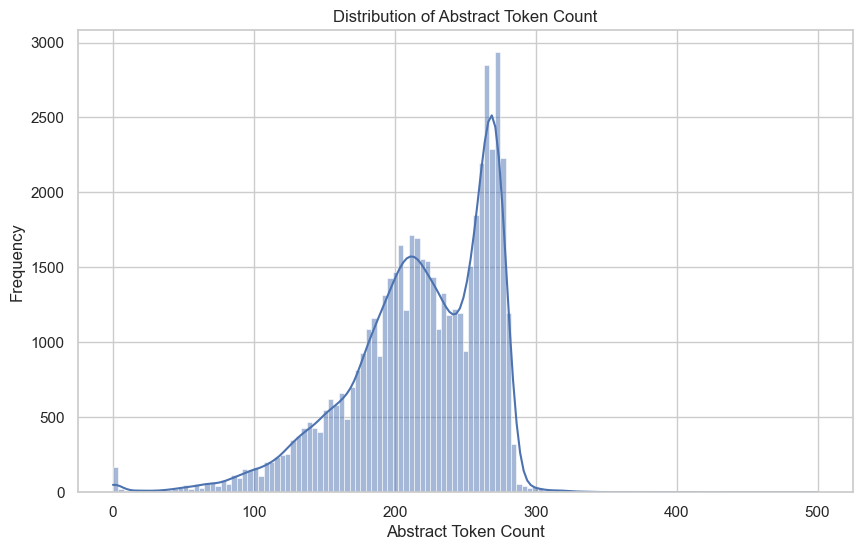

In [46]:
# Histogram for abstract token count
plt.figure(figsize=(10, 6))
sns.histplot(results_json['abstract_token_count'], kde=True)
plt.title('Distribution of Abstract Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Frequency')
plt.show()

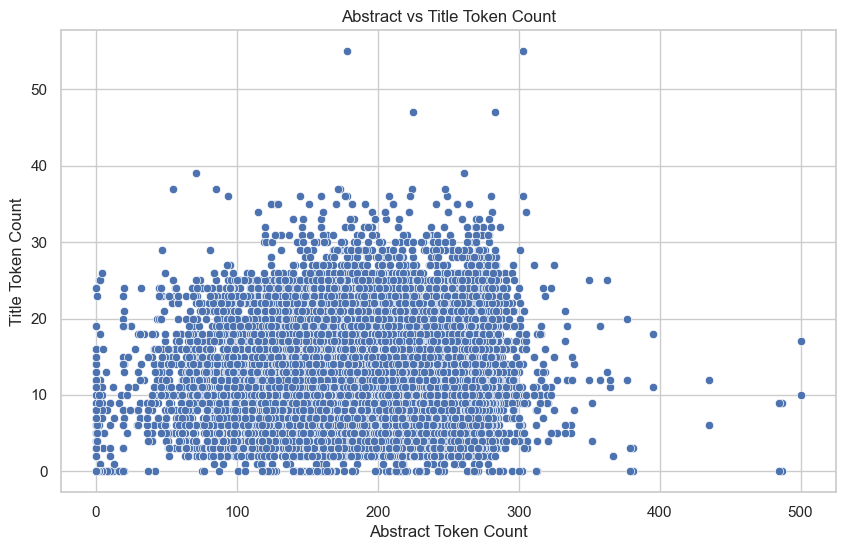

In [47]:
# Scatter plot for abstract vs title token count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_json, x='abstract_token_count', y='title_token_count')
plt.title('Abstract vs Title Token Count')
plt.xlabel('Abstract Token Count')
plt.ylabel('Title Token Count')
plt.show()

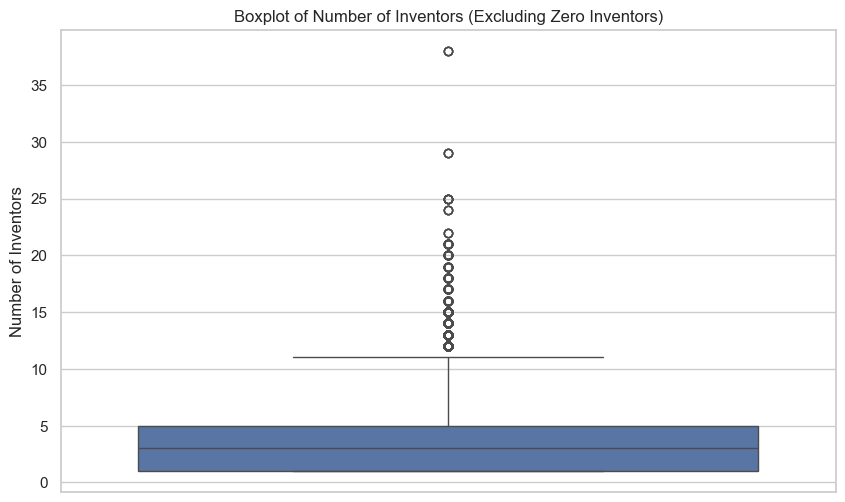

In [48]:
# Boxplot for number of inventors
# Exclude rows with zero inventors.
filtered_data = results_json[results_json['num_inventors'] > 0]

# Now, we can create a boxplot for the number of inventors.
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, y='num_inventors')
plt.title('Boxplot of Number of Inventors (Excluding Zero Inventors)')
plt.ylabel('Number of Inventors')
plt.show()

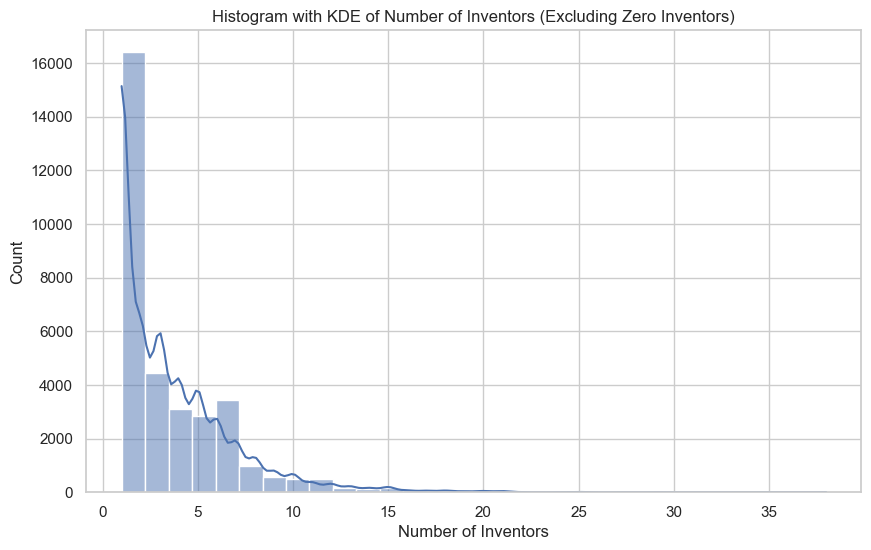

In [49]:
# Kernel Density Estimate (KDE) plot
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['num_inventors'], bins=30, kde=True)
plt.title('Histogram with KDE of Number of Inventors (Excluding Zero Inventors)')
plt.xlabel('Number of Inventors')
plt.ylabel('Count')
plt.show()

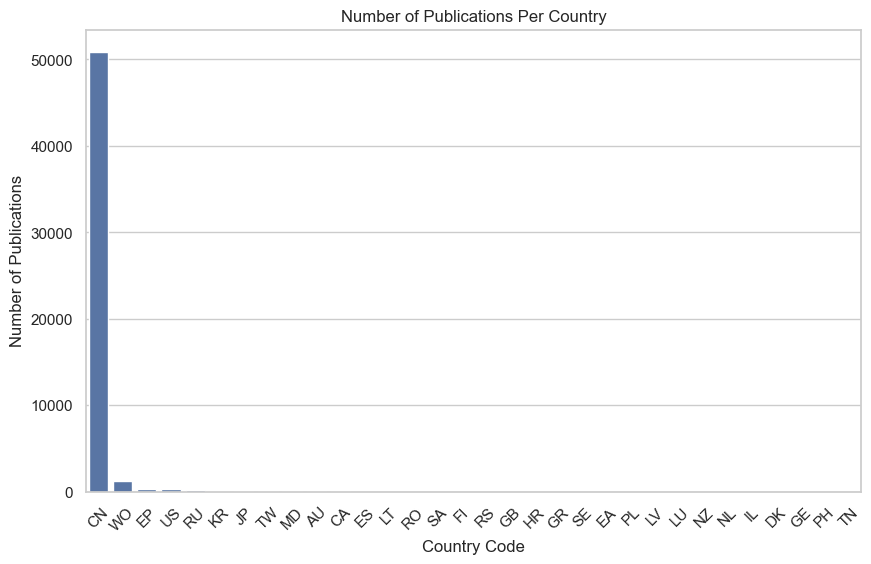

In [50]:
# Bar chart for publications per country
plt.figure(figsize=(10, 6))
sns.countplot(data=results_json, x='country_code', order=results_json['country_code'].value_counts().index)
plt.title('Number of Publications Per Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Publications')
plt.xticks(rotation=45)
plt.show()

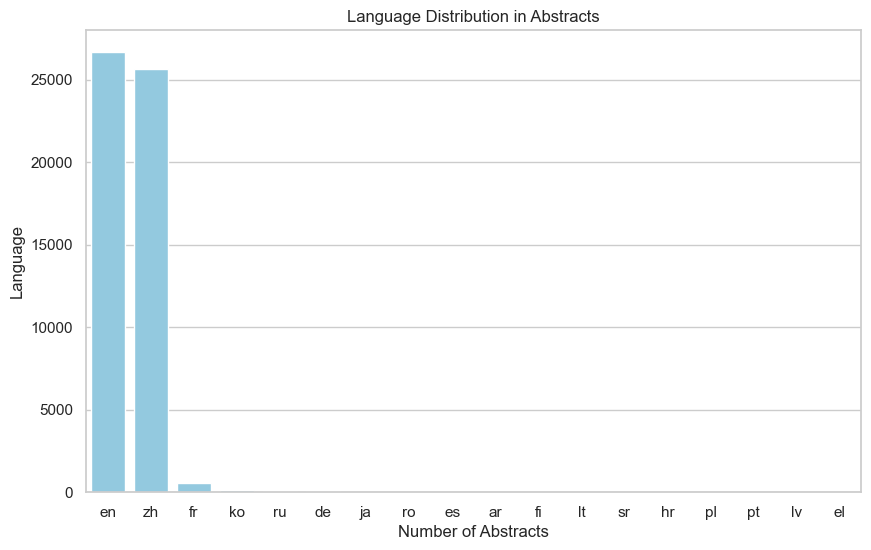

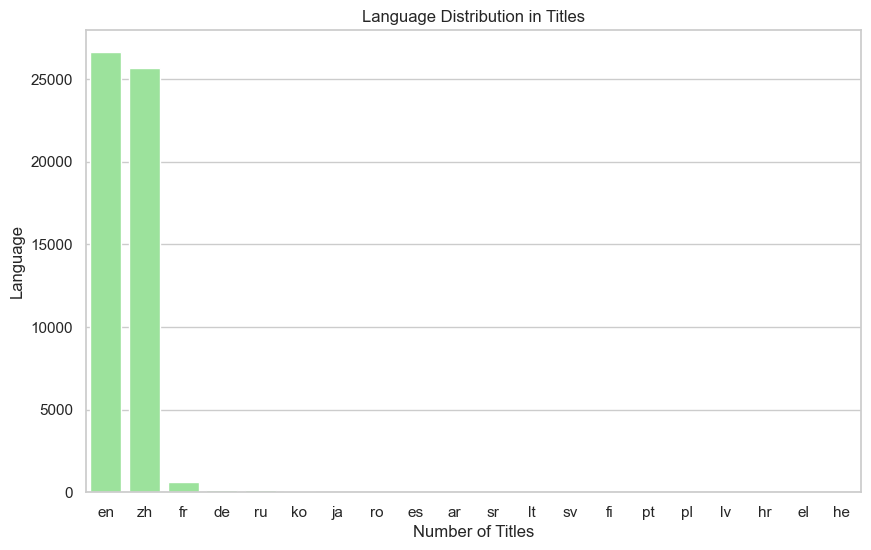

In [51]:
# Plot for language distribution in abstracts
plt.figure(figsize=(10, 6))
sns.barplot(x=[item[0] for item in abstract_lang_distribution.values], y=[item[1] for item in abstract_lang_distribution.values], color='skyblue')
plt.title('Language Distribution in Abstracts')
plt.xlabel('Number of Abstracts')
plt.ylabel('Language')
plt.show()

# Plot for language distribution in titles
plt.figure(figsize=(10, 6))
sns.barplot(x=[item[0] for item in title_lang_distribution.values], y=[item[1] for item in title_lang_distribution.values], color='lightgreen')
plt.title('Language Distribution in Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Language')
plt.show()


#### UNIGRAMS 

#### Unigram with stopwords

In [52]:
# Function to get top n unigrams
def get_top_n_words(corpus, n=None, stopwords=None):
    vec = CountVectorizer(stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [53]:
top_n_unigrams = get_top_n_words(results_json['abstract_localized_text'], n=20)
df_unigrams = pd.DataFrame(top_n_unigrams, columns=['word', 'count'])

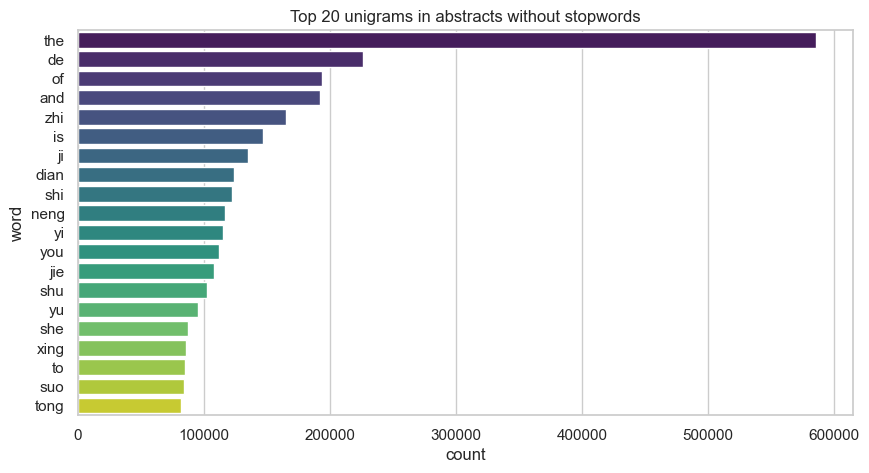

In [54]:
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=df_unigrams, palette='viridis', hue='word')
plt.title('Top 20 unigrams in abstracts without stopwords')
plt.show()

#### Unigram without stopwords

In [55]:
top_n_unigrams_stop = get_top_n_words(results_json['abstract_localized_text'], n=20, stopwords='english')
df_unigrams_stop = pd.DataFrame(top_n_unigrams_stop, columns=['word', 'count'])

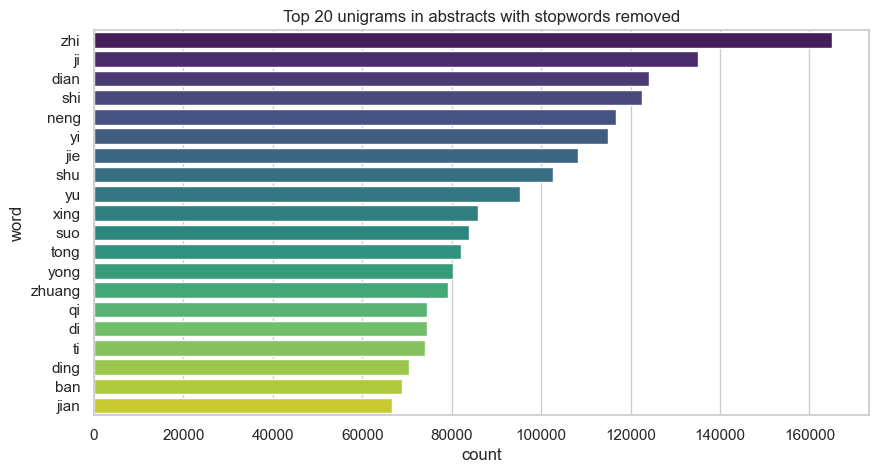

In [56]:
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='word', data=df_unigrams_stop, palette='viridis', hue='word')
plt.title('Top 20 unigrams in abstracts with stopwords removed')
plt.show()

#### Bigrams 

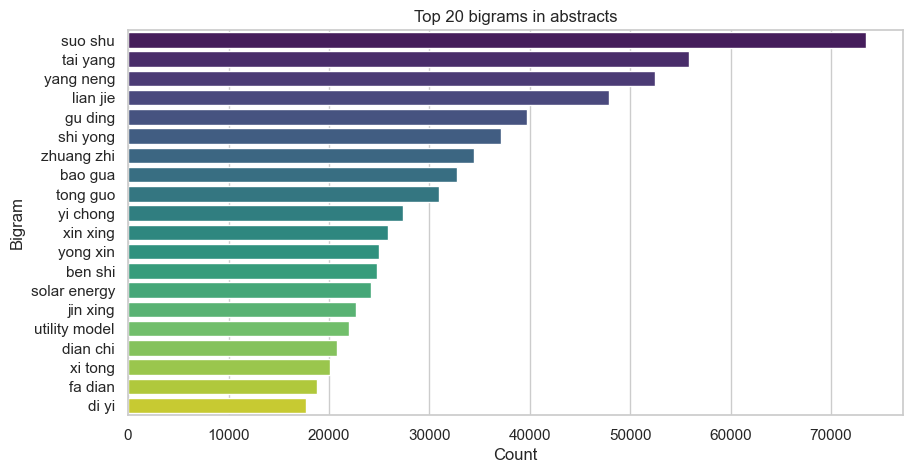

In [57]:
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Assuming 'results_json' is your DataFrame and 'abstract_text' is the column with abstracts
# Get the top n bigrams from the abstracts
top_n_bigrams = get_top_n_bigrams(results_json['abstract_localized_text'], n=20)
df_bigrams = pd.DataFrame(top_n_bigrams, columns=['bigram', 'count'])

# Plot the top n bigrams
plt.figure(figsize=(10, 5))
sns.barplot(x='count', y='bigram', data=df_bigrams, palette='viridis', hue='bigram')
plt.title('Top 20 bigrams in abstracts')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

#### Handle duplicates 


We decided to handle duplicates after convertion of columns (for easier process and to avoid overwriting the code).

In [58]:
# Convert list columns to strings to enable hashing
results_json['abstract_tokens_str'] = results_json['abstract_tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
results_json['title_tokens_str'] = results_json['title_tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Temporarily drop columns that may contain complex data types like lists or dicts
temp_df = results_json.drop(columns=['abstract_tokens', 'title_tokens', 'inventor'])

# Now check for duplicates in this temporary DataFrame
duplicates = temp_df.duplicated(subset=None, keep='first').sum()
print(f"Remaining duplicates: {duplicates}")

# If you want to remove duplicates, do so and then add back the dropped columns
#if duplicates > 0:
    #results_json = results_json.loc[~temp_df.duplicated(subset=None, keep='first')].reset_index(drop=True)

# You can drop duplicates if needed using the following line:
# results_json = results_json.drop_duplicates(subset=None, keep='first').reset_index(drop=True)


Remaining duplicates: 46


In [59]:
# Identify duplicates
is_duplicate = temp_df.duplicated(subset=None, keep='first')
is_duplicate.head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

In [60]:
# Remove duplicates
results_json = results_json[~is_duplicate].reset_index(drop=True)

# Print the head of the DataFrame to inspect the first few rows
results_json.head()
#Mabye add this step before visualizations.

,publication_number,application_number,country_code,publication_date,inventor,title_localized_text,title_localized_language,abstract_localized_text,abstract_localized_language,num_inventors,multiple_inventors,abstract_tokens,title_tokens,abstract_token_count,title_token_count,abstract_tokens_str,title_tokens_str
0,US-2022239235-A1,US-202217717397-A,US,2022-07-28,None,adaptable dc ac inverter drive system and oper...,en,disclosed is an adaptable dc ac inverter syste...,en,0,0,"[disclosed, is, an, adaptable, dc, ac, inverte...","[adaptable, dc, ac, inverter, drive, system, a...",67,8,disclosed is an adaptable dc ac inverter syste...,adaptable dc ac inverter drive system and oper...
1,US-2022239251-A1,US-202217580956-A,US,2022-07-28,None,system for providing the energy from a single ...,en,in accordance with an example embodiment a sol...,en,0,0,"[in, accordance, with, an, example, embodiment...","[system, for, providing, the, energy, from, a,...",92,18,in accordance with an example embodiment a sol...,system for providing the energy from a single ...
2,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",verfahren zum steuern einer windenergieanlage,de,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[verfahren, zum, steuern, einer, windenergiean...",208,5,verfahren zum steuern einer windenergieanlage ...,verfahren zum steuern einer windenergieanlage
3,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",verfahren zum steuern einer windenergieanlage,de,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[verfahren, zum, steuern, einer, windenergiean...",207,5,verfahren zum steuern einer windenergieanlage ...,verfahren zum steuern einer windenergieanlage
4,EP-4033090-A1,EP-21152924-A,EP,2022-07-27,"[Schaper, Ulf, Von Aswege, Enno, Gerke Funcke,...",method for controlling a wind energy system,en,verfahren zum steuern einer windenergieanlage ...,de,3,1,"[verfahren, zum, steuern, einer, windenergiean...","[method, for, controlling, a, wind, energy, sy...",208,7,verfahren zum steuern einer windenergieanlage ...,method for controlling a wind energy system


## CSV PROCESSING

#### CT_Evaluation cleaning

In [61]:
#Look into data frame already uploaded at the beginning of the notebook
ct_evaluation.head(24)

,example_id,question_id,question,relevant_chunk,article_url
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,https://www.pv-magazine.com/2023/02/02/europea...
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,https://cleantechnica.com/2023/05/08/general-m...
5,6,5,Did Colgate-Palmolive enter into PPA agreement...,"Scout Clean Energy, a Colorado-based renewable...",https://solarindustrymag.com/scout-and-colgate...
6,7,6,What is the status of ZeroAvia's hydrogen fuel...,"In December, the US startup ZeroAvia announced...",https://cleantechnica.com/2023/01/02/the-wait-...
7,8,7,"What is the ""Danger Season""?",As spring turns to summer and the days warm up...,https://cleantechnica.com/2023/05/15/what-does...
8,9,8,Is Mississipi an anti-ESG state?,Mississippi is among two dozen or so states in...,https://cleantechnica.com/2023/05/15/mississip...
9,10,9,Can you hang solar panels on garden fences?,Scaling down from the farm to the garden level...,https://cleantechnica.com/2023/05/18/solar-pan...


In [62]:
print("\nData information:")
ct_evaluation.info()


Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   example_id      23 non-null     int64 
 1   question_id     23 non-null     int64 
 2   question        23 non-null     object
 3   relevant_chunk  23 non-null     object
 4   article_url     23 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.0+ KB


In [63]:
# Check for missing values in each column
missing_data = ct_evaluation.isnull().sum()
print("Missing values in each column:")
missing_data
# No missing data, which simplyify our cleaning steps

Missing values in each column:


example_id        0
question_id       0
question          0
relevant_chunk    0
article_url       0
dtype: int64

In [64]:
def generate_summary(df):
    # Identify non-hashable columns (e.g., columns with lists)
    non_hashable_columns = [col for col in df.columns if isinstance(df[col].dropna().iloc[0], list)]
    
    # Exclude non-hashable columns from the nunique calculation
    hashable_columns = df.drop(columns=non_hashable_columns)
    
    # Essentials: type, unique values, missing values
    summary = pd.DataFrame({
        'type': df.dtypes,
        'unique_values': hashable_columns.nunique(),
        'missing_values': df.isnull().sum()
    })
    
    # Quantile statistics for numeric columns only
    numeric_cols = df.select_dtypes(include='number')
    quantiles = numeric_cols.quantile([0, 0.25, 0.5, 0.75, 1]).transpose()
    
    # Add quantile stats to the summary
    summary_stats = pd.concat([summary, quantiles], axis=1, sort=False)
    
    # Compute range and interquartile range (IQR)
    if not numeric_cols.empty:  # Only calculate if there are numeric columns
        summary_stats['range'] = summary_stats[1.0] - summary_stats[0.0]
        summary_stats['iqr'] = summary_stats[0.75] - summary_stats[0.25]
    
    return summary_stats

# Apply the summary function to your datasets
ct_evaluation_summary = generate_summary(ct_evaluation)
# ct_media_summary = generate_summary(ct_media) # Uncomment when needed

# Display the summaries
print("Summary for ct_evaluation:")
ct_evaluation_summary


Summary for ct_evaluation:


,type,unique_values,missing_values,0.0,0.25,0.5,0.75,1.0,range,iqr
example_id,int64,23,0,1.0,6.5,12.0,17.5,23.0,22.0,11.0
question_id,int64,21,0,1.0,5.5,11.0,16.5,21.0,20.0,11.0
question,object,21,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relevant_chunk,object,23,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
article_url,object,21,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# Look into unique characters to indentify which ones to remove
# Create sets to hold unique characters
unique_chars_question = set()
unique_chars_chunk = set()

# Update sets with characters from each row
for question, chunk in zip(ct_evaluation['question'], ct_evaluation['relevant_chunk']):
    unique_chars_question.update(question)
    unique_chars_chunk.update(chunk)

# Print the unique characters
print("Unique characters in 'question' column:")
print(sorted(unique_chars_question))
print("\nUnique characters in 'relevant_chunk' column:")
print(sorted(unique_chars_chunk))

Unique characters in 'question' column:
[' ', '"', "'", ',', '-', '0', '1', '2', '3', '5', '?', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'L', 'M', 'P', 'S', 'U', 'W', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'é', '’']

Unique characters in 'relevant_chunk' column:
[' ', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '8', '9', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '–', '’', '“', '”']


In [66]:
# Initialize a lemmatizer
lemmatizer = WordNetLemmatizer()

def standardize_text(text):
    # Normalize and convert to lowercase
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    
    # Replace special apostrophes and quotation marks
    text = text.replace('’', "'").replace('“', '"').replace('”', '"')
    
    # Standardize dashes
    text = text.replace('–', '-')  # Replace en-dash with hyphen
    
    #remove links
    text = re.sub(r'<[^>]*>', ' ', text)
    
    # Remove punctuation and numbers
    text = re.sub(r'[\W_]+', ' ', text)  # \W_ matches any non-alphanumeric character underscore included
    
    return text
    

# Apply the cleaning function to both 'question' and 'relevant_chunk' columns
ct_evaluation['question'] = ct_evaluation['question'].apply(standardize_text)
ct_evaluation['relevant_chunk'] = ct_evaluation['relevant_chunk'].apply(standardize_text)

# Display the cleaned text to confirm changes
print("Standardized 'question' column:")
print(ct_evaluation['question'].head())
print("\nStandardized 'relevant_chunk' column:")
print(ct_evaluation['relevant_chunk'].head())
##Should we remove numbers as well?

Standardized 'question' column:
0    what is the innovation behind leclanche s new ...
1          what is the eus green deal industrial plan 
2          what is the eus green deal industrial plan 
3    what are the four focus areas of the eu s gree...
4    when did the cooperation between gm and honda ...
Name: question, dtype: object

Standardized 'relevant_chunk' column:
0    leclanche said it has developed an environment...
1    the green deal industrial plan is a bid by the...
2    the european counterpart to the us inflation r...
3    the new plan is fundamentally focused on four ...
4    what caught our eye was a new hookup between g...
Name: relevant_chunk, dtype: object


In [67]:
# Function to extract unique characters from text
def extract_unique_characters(text_series):
    unique_characters = set()
    for text in text_series:
        unique_characters.update(text)
    return sorted(unique_characters)

# Apply the function to cleaned 'question' and 'relevant_chunk' columns
unique_chars_in_question_cleaned = extract_unique_characters(ct_evaluation['question'])
unique_chars_in_chunk_cleaned = extract_unique_characters(ct_evaluation['relevant_chunk'])

# Display the unique characters
print("Unique characters in cleaned 'question' column:")
print(unique_chars_in_question_cleaned)
print("\nUnique characters in cleaned 'relevant_chunk' column:")
print(unique_chars_in_chunk_cleaned)

Unique characters in cleaned 'question' column:
[' ', '0', '1', '2', '3', '5', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']

Unique characters in cleaned 'relevant_chunk' column:
[' ', '0', '1', '2', '3', '4', '5', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [68]:
# Function to count tokens in text
def count_tokens(text):
    return len(text.split())

# Count tokens and create new columns
ct_evaluation['question_token_count'] = ct_evaluation['question'].apply(count_tokens)
ct_evaluation['relevant_chunk_token_count'] = ct_evaluation['relevant_chunk'].apply(count_tokens)

# Display the DataFrame to confirm changes
print("\nDataFrame with token counts:")
print(ct_evaluation[['question', 'question_token_count', 'relevant_chunk', 'relevant_chunk_token_count']].head())


DataFrame with token counts:
                                            question  question_token_count  \
0  what is the innovation behind leclanche s new ...                    14   
1        what is the eus green deal industrial plan                      8   
2        what is the eus green deal industrial plan                      8   
3  what are the four focus areas of the eu s gree...                    14   
4  when did the cooperation between gm and honda ...                    13   

                                      relevant_chunk  \
0  leclanche said it has developed an environment...   
1  the green deal industrial plan is a bid by the...   
2  the european counterpart to the us inflation r...   
3  the new plan is fundamentally focused on four ...   
4  what caught our eye was a new hookup between g...   

   relevant_chunk_token_count  
0                          42  
1                          47  
2                          37  
3                          42  
4   

#### URL cleaning

In [69]:
# Summary of the article_url column
url_summary = ct_evaluation['article_url'].agg(['dtype', 'nunique', 'count', pd.Series.nunique, pd.Series.unique])

# Check for missing values
url_summary['missing_values'] = ct_evaluation['article_url'].isnull().sum()

# Display the summary
url_summary

dtype                                                        object
nunique                                                          21
count                                                            23
nunique                                                          21
unique            [https://www.sgvoice.net/strategy/technology/2...
missing_values                                                    0
Name: article_url, dtype: object

In [70]:
def clean_url(url):
    # Parse the URL
    parsed_url = urlparse(url.lower())
    # Reconstruct without query and fragment
    cleaned_url = urlunparse((parsed_url.scheme, parsed_url.netloc, parsed_url.path, '', '', ''))
    return cleaned_url

def extract_domain(url):
    # Parse the URL and extract the domain
    domain = urlparse(url.lower()).netloc
    # Remove 'www.' if it exists
    domain = domain.replace('www.', '')
    # Extract only the main part of the domain before the first dot
    main_part = domain.split('.')[0]
    return main_part

# Apply cleaning to the article_url column
ct_evaluation['cleaned_article_url'] = ct_evaluation['article_url'].apply(clean_url)
ct_evaluation['domain'] = ct_evaluation['article_url'].apply(extract_domain)

# Display the cleaned URLs and domains
ct_evaluation[['article_url', 'cleaned_article_url', 'domain']]

,article_url,cleaned_article_url,domain
0,https://www.sgvoice.net/strategy/technology/23...,https://www.sgvoice.net/strategy/technology/23...,sgvoice
1,https://www.sgvoice.net/policy/25396/eu-seeks-...,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
2,https://www.pv-magazine.com/2023/02/02/europea...,https://www.pv-magazine.com/2023/02/02/europea...,pv-magazine
3,https://www.sgvoice.net/policy/25396/eu-seeks-...,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
4,https://cleantechnica.com/2023/05/08/general-m...,https://cleantechnica.com/2023/05/08/general-m...,cleantechnica
5,https://solarindustrymag.com/scout-and-colgate...,https://solarindustrymag.com/scout-and-colgate...,solarindustrymag
6,https://cleantechnica.com/2023/01/02/the-wait-...,https://cleantechnica.com/2023/01/02/the-wait-...,cleantechnica
7,https://cleantechnica.com/2023/05/15/what-does...,https://cleantechnica.com/2023/05/15/what-does...,cleantechnica
8,https://cleantechnica.com/2023/05/15/mississip...,https://cleantechnica.com/2023/05/15/mississip...,cleantechnica
9,https://cleantechnica.com/2023/05/18/solar-pan...,https://cleantechnica.com/2023/05/18/solar-pan...,cleantechnica


In [71]:
# inspect again
ct_evaluation.head(24)

,example_id,question_id,question,relevant_chunk,article_url,question_token_count,relevant_chunk_token_count,cleaned_article_url,domain
0,1,1,what is the innovation behind leclanche s new ...,leclanche said it has developed an environment...,https://www.sgvoice.net/strategy/technology/23...,14,42,https://www.sgvoice.net/strategy/technology/23...,sgvoice
1,2,2,what is the eus green deal industrial plan,the green deal industrial plan is a bid by the...,https://www.sgvoice.net/policy/25396/eu-seeks-...,8,47,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
2,3,2,what is the eus green deal industrial plan,the european counterpart to the us inflation r...,https://www.pv-magazine.com/2023/02/02/europea...,8,37,https://www.pv-magazine.com/2023/02/02/europea...,pv-magazine
3,4,3,what are the four focus areas of the eu s gree...,the new plan is fundamentally focused on four ...,https://www.sgvoice.net/policy/25396/eu-seeks-...,14,42,https://www.sgvoice.net/policy/25396/eu-seeks-...,sgvoice
4,5,4,when did the cooperation between gm and honda ...,what caught our eye was a new hookup between g...,https://cleantechnica.com/2023/05/08/general-m...,13,61,https://cleantechnica.com/2023/05/08/general-m...,cleantechnica
5,6,5,did colgate palmolive enter into ppa agreement...,scout clean energy a colorado based renewable ...,https://solarindustrymag.com/scout-and-colgate...,10,34,https://solarindustrymag.com/scout-and-colgate...,solarindustrymag
6,7,6,what is the status of zeroavia s hydrogen fuel...,in december the us startup zeroavia announced ...,https://cleantechnica.com/2023/01/02/the-wait-...,12,30,https://cleantechnica.com/2023/01/02/the-wait-...,cleantechnica
7,8,7,what is the danger season,as spring turns to summer and the days warm up...,https://cleantechnica.com/2023/05/15/what-does...,5,88,https://cleantechnica.com/2023/05/15/what-does...,cleantechnica
8,9,8,is mississipi an anti esg state,mississippi is among two dozen or so states in...,https://cleantechnica.com/2023/05/15/mississip...,6,29,https://cleantechnica.com/2023/05/15/mississip...,cleantechnica
9,10,9,can you hang solar panels on garden fences,scaling down from the farm to the garden level...,https://cleantechnica.com/2023/05/18/solar-pan...,8,53,https://cleantechnica.com/2023/05/18/solar-pan...,cleantechnica


#### Remove stopwords

In [72]:
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Remove stopwords from 'question' and 'relevant_chunk'
ct_evaluation['question_clean'] = ct_evaluation['question'].apply(remove_stopwords)
ct_evaluation['relevant_chunk_clean'] = ct_evaluation['relevant_chunk'].apply(remove_stopwords)


#### Co-occurrances analysation

In [73]:
# Function to calculate co-occurrences
def calculate_cooccurrences(data, column):
    # Define a count vectorizer
    count_vectorizer = CountVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words='english',
        binary=True
    )

    # Transform the text into binary flags
    counts = count_vectorizer.fit_transform(data[column])

    # Get the names of each column
    ngrams = count_vectorizer.get_feature_names_out()

    # Compute the product to get a co-occurrence matrix
    cooccurs = (counts.T * counts)

    # Fill the diagonal with zeros
    cooccurs.setdiag(0)

    # Convert to a dense format and make a DataFrame
    cooccurs_df = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
    
    return cooccurs_df

# Calculate co-occurrences for the 'abstract_text' column
cooccurs_question = calculate_cooccurrences(ct_evaluation, 'question')

# Calculate co-occurrences for the 'title_text' column
cooccurs_relevant_chunk = calculate_cooccurrences(ct_evaluation, 'relevant_chunk')

# Display the co-occurrence DataFrames
print("Co-occurrences in question:")
cooccurs_question.head()


Co-occurrences in question:


,2021,500m,absorption,agreements,agrivoltaics,aircraft,amorphous,anti,apples,areas,...,total,turbines,used,user,using,vehicles,warming,wavelengths,winters,zeroavia
2021,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
500m,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
absorption,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
agreements,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agrivoltaics,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
print("\nCo-occurrences in relevant_chunk:")
cooccurs_relevant_chunk.head()


Co-occurrences in relevant_chunk:


,14,19,200,2012,2013,2021,2030,209,228,500,...,white,wildfire,wildfires,winter,wintertime,worked,year,years,zero,zeroavia
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
200,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2012,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [75]:
# Define a count vectorizer that will create binary flags indicating the presence of each word
count_vectorizer = CountVectorizer(
    min_df=.08,
    max_df=100,
    stop_words='english',
    binary=True
)
# Transform the text into binary flags
counts_question = count_vectorizer.fit_transform(ct_evaluation, 'question')
counts_relevant_chunk = count_vectorizer.fit_transform(ct_evaluation, 'relevant_chunk')

# Get the names of each column
ngrams = count_vectorizer.get_feature_names_out()
# Compute the product to get a co-occurrence matrix
cooccurs = (counts_question.T * counts_question)  # Calculate co-occurrence for questions
cooccurs += (counts_relevant_chunk.T * counts_relevant_chunk)  # Add co-occurrence for relevant chunks
# Fill the diagonal with zeroes
cooccurs.setdiag(0)
# Put it into a Pandas DataFrame to make it pretty
cooccurs = pd.DataFrame(cooccurs.todense(), index=ngrams, columns=ngrams)
cooccurs.head()

,article_url,cleaned_article_url,domain,example_id,question,question_clean,question_id,question_token_count,relevant_chunk,relevant_chunk_clean,relevant_chunk_token_count
article_url,0,0,0,0,0,0,0,0,0,0,0
cleaned_article_url,0,0,0,0,0,0,0,0,0,0,0
domain,0,0,0,0,0,0,0,0,0,0,0
example_id,0,0,0,0,0,0,0,0,0,0,0
question,0,0,0,0,0,0,0,0,0,0,0


In [76]:
def calculate_cooccurrences(texts, max_df, min_df, stop_words, binary):
    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, binary=binary)
    X = vectorizer.fit_transform(texts)
    Xc = (X.T * X)  # This is the matrix manipulation step
    Xc.setdiag(0)  # We set the diagonal to be zeroes as we don't want to count self co-occurrences
    names = vectorizer.get_feature_names_out()
    return pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

# Assuming 'ct_evaluation' is your dataframe and it has columns 'question' and 'relevant_chunk'
# We also assume that the texts have been preprocessed and tokenized if necessary.

# Calculate co-occurrences, ensure to set min_df to a value that makes sense for your dataset size
question_cooccurrences = calculate_cooccurrences(ct_evaluation['question'], 
                                                 max_df=0.9, min_df=5, 
                                                 stop_words='english', binary=True)
chunk_cooccurrences = calculate_cooccurrences(ct_evaluation['relevant_chunk'], 
                                              max_df=0.9, min_df=5, 
                                              stop_words='english', binary=True)

# Now you can display the head of these dataframes
print(question_cooccurrences.head())
print(chunk_cooccurrences.head())



       solar
solar      0
       solar
solar      0


#### Worldcloud

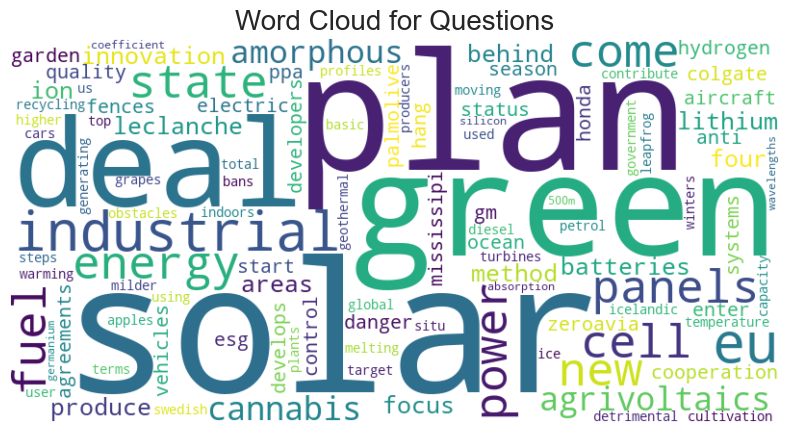

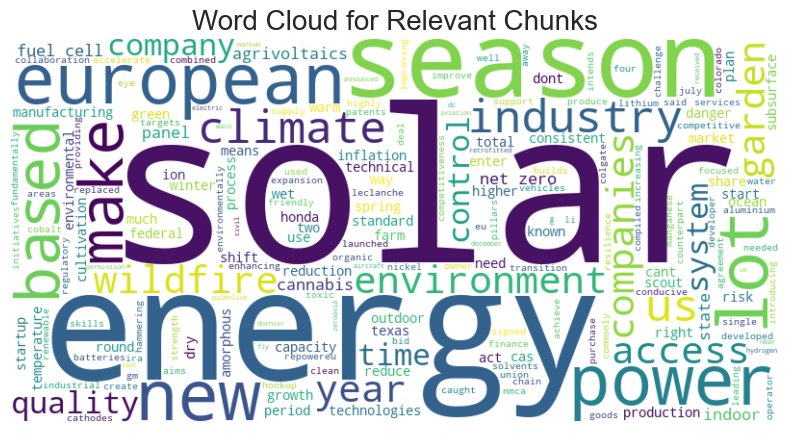

In [77]:
# Generate word cloud for questions
wordcloud_question = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(ct_evaluation['question_clean']))
wordcloud_chunk = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(ct_evaluation['relevant_chunk_clean']))

# Display the WordCloud image for questions
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_question, interpolation='bilinear')
plt.title('Word Cloud for Questions', fontsize=20)
plt.axis("off")
plt.show()

# Display the WordCloud image for relevant chunks
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_chunk, interpolation='bilinear')
plt.title('Word Cloud for Relevant Chunks', fontsize=20)
plt.axis("off")
plt.show()

#### CT_Media Cleaning

In [78]:
print("First few rows:")
print(ct_media.head())
#rename the unnamed column name, make a plot for date input, 

First few rows:
   Unnamed: 0                                              title        date  \
0        1280  Qatar to Slash Emissions as LNG Expansion Adva...  2021-01-13   
1        1281               India Launches Its First 700 MW PHWR  2021-01-15   
2        1283              New Chapter for US-China Energy Trade  2021-01-20   
3        1284  Japan: Slow Restarts Cast Doubt on 2030 Energy...  2021-01-22   
4        1285     NYC Pension Funds to Divest Fossil Fuel Shares  2021-01-25   

  author                                            content       domain  \
0    NaN  ["Qatar Petroleum ( QP) is targeting aggressiv...  energyintel   
1    NaN  ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...  energyintel   
2    NaN  ["New US President Joe Biden took office this ...  energyintel   
3    NaN  ["The slow pace of Japanese reactor restarts c...  energyintel   
4    NaN  ["Two of New York City's largest pension funds...  energyintel   

                                              

In [79]:
def generate_summary(df):
    # Essentials: type, unique values, missing values
    summary = pd.DataFrame({
        'type': df.dtypes,
        'unique_values': df.nunique(),
        'missing_values': df.isnull().sum()
    })
    
    # Quantile statistics for numeric columns only
    numeric_cols = df.select_dtypes(include='number')
    quantiles = numeric_cols.quantile([0, 0.25, 0.5, 0.75, 1]).transpose()
    
    # Add quantile stats to the summary
    summary_stats = pd.concat([summary, quantiles], axis=1)
    
    # Compute range and interquartile range (IQR)
    summary_stats['range'] = summary_stats[1.0] - summary_stats[0.0]
    summary_stats['iqr'] = summary_stats[0.75] - summary_stats[0.25]
    
    return summary_stats

# Apply the summary function to both datasets
ct_media_summary = generate_summary(ct_media)

# Display the summaries
print("\nSummary for ct_media:")
print(ct_media_summary)


Summary for ct_media:
              type  unique_values  missing_values     0.0     0.25      0.5  \
Unnamed: 0   int64           9593               0  1280.0  17156.0  45991.0   
title       object           9569               0     NaN      NaN      NaN   
date        object            967               0     NaN      NaN      NaN   
author      object              7            9562     NaN      NaN      NaN   
content     object           9588               0     NaN      NaN      NaN   
domain      object             19               0     NaN      NaN      NaN   
url         object           9593               0     NaN      NaN      NaN   

               0.75      1.0    range      iqr  
Unnamed: 0  79250.0  81816.0  80536.0  62094.0  
title           NaN      NaN      NaN      NaN  
date            NaN      NaN      NaN      NaN  
author          NaN      NaN      NaN      NaN  
content         NaN      NaN      NaN      NaN  
domain          NaN      NaN      NaN      NaN  
u

In [80]:
# Handle date, look into consistency and earlies and latest date
# Check the earliest and latest dates
print("Earliest date:", ct_media['date'].min())
print("Latest date:", ct_media['date'].max())

# Check the frequency of each date to identify any unusual patterns
date_counts = ct_media['date'].value_counts().sort_index()
print("Date frequencies:\n", date_counts.head())

Earliest date: 2021-01-01
Latest date: 2023-12-05
Date frequencies:
 date
2021-01-01    3
2021-01-02    1
2021-01-03    2
2021-01-04    5
2021-01-05    8
Name: count, dtype: int64


In [81]:
def unique_characters(column):
    return set(''.join(column))

# Load your data (assuming DataFrame is named ct_media)
# ct_media = pd.read_csv('path_to_your_file.csv')

# Inspect unique characters in the title
title_chars = unique_characters(ct_media['title'])
print("Unique characters in 'title':", title_chars)

# Inspect unique characters in the content
content_chars = unique_characters(ct_media['content'])
print("Unique characters in 'content':", content_chars)


Unique characters in 'title': {'⅓', '”', '~', '!', 'r', 't', 'D', ',', 'f', 'N', 'S', 'F', '‘', 'd', 'ë', '4', '$', '%', 'â', '5', '£', '⅙', 'Z', '\u200b', 'e', 'C', "'", '1', '[', 'H', 'y', 'X', '®', 'u', 'G', 'U', '.', '8', '-', 'P', '`', 'w', 'J', 'c', '9', 'b', 'z', 'T', 'M', '0', 'Q', '+', 'q', 'à', 'E', 'n', 'ó', '6', 'l', ']', 'V', 'L', '₂', '7', 'ú', '“', 'ä', 'o', '*', 'm', 'p', '#', 'ç', '–', 'ü', ')', '×', 'j', 'I', 'W', '?', '€', 'A', 'ö', 'á', '½', 'Y', ' ', '3', '@', '>', 'g', 'Ø', 'B', 'v', 'a', 'ø', 'k', 'O', 'í', 'ē', 'å', '=', '2', '’', 'K', 's', 'x', '°', 'h', 'Ö', '&', '(', '/', 'É', '—', ';', 'R', ':', 'é', 'i', '™', '…'}
Unique characters in 'content': {'µ', '\\', '🇩', 'ß', '⅓', '”', 'ț', '🇲', 'ô', '!', 'f', 'ї', '👀', '4', '℃', '₃', '%', 'ه', 'ق', '🔸', '£', 'Ô', 'в', '‐', 'Л', '1', '회', 'ć', '[', '✔', '🇨', '～', 'X', 'u', 'ễ', '👇', 'э', '-', '̶', 'P', '🏛', '🇳', 'J', 'z', 'т', 'ε', 'Ü', '🚗', '✊', 'l', 'L', 'Æ', '7', 'ž', '🔗', 'و', 'm', '✖', '¼', '🏽', '🇽', '🙂', '„', 

### Cleaning Title

In [82]:
def clean_title(text):
    # Normalize unicode characters and convert to lower
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    # Remove special characters
    text = re.sub(r'[^\w\s-]', '', text)
    return text

# Apply the cleaning function to the title column
ct_media['title'] = ct_media['title'].apply(clean_title)

# Display the cleaned titles
print(ct_media['title'].head())

#examine unique characters again
title_chars = unique_characters(ct_media['title'])
print("Unique characters in 'title':", title_chars)

0    qatar to slash emissions as lng expansion adva...
1                 india launches its first 700 mw phwr
2                new chapter for us-china energy trade
3    japan slow restarts cast doubt on 2030 energy ...
4       nyc pension funds to divest fossil fuel shares
Name: title, dtype: object
Unique characters in 'title': {'v', '7', 'a', 'y', 'o', 'k', 'u', 'm', 'p', 'r', 't', '8', '-', 'f', 'w', 'c', 'j', '2', '9', 's', 'b', 'x', 'z', 'd', 'h', '4', '0', 'q', '5', ' ', '3', 'n', 'e', 'i', '1', '6', 'l', 'g'}


### Cleaning content

In [83]:
def clean_content(text):
    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()
    # Remove HTML tags (if any)
    text = re.sub(r'<[^>]+>', '', text)
    # Remove emojis
    text = re.sub(r'[^\w\s.,-]', '', text)
    return text

# Apply the cleaning function to the content column
ct_media['content'] = ct_media['content'].apply(clean_content)

# Display the cleaned content
print(ct_media['content'].head())

# Inspect unique characters in the content
content_chars = unique_characters(ct_media['content'])
print("Unique characters in 'content':", content_chars)

0    qatar petroleum  qp is targeting aggressive cu...
1     nuclear power corp. of india ltd.  npcil sync...
2    new us president joe biden took office this we...
3    the slow pace of japanese reactor restarts con...
4    two of new york citys largest pension funds sa...
Name: content, dtype: object
Unique characters in 'content': {'v', '7', 'a', 'y', 'o', 'k', 'u', 'p', 'm', 'r', 't', '8', '.', '-', ',', 'f', 'w', 'c', '2', 'j', '9', 's', 'b', 'x', 'z', 'd', 'h', '4', '0', 'q', '5', ' ', '3', 'n', 'e', 'i', '1', '6', 'l', 'g'}


#### TOKANIZATION


In [84]:
# You might need to download the NLTK tokenizer resources
#nltk.download('punkt')

# Applying tokenization
ct_media['tokenized_content'] = ct_media['content'].apply(word_tokenize)
ct_media['tokenized_title'] = ct_media['title'].apply(word_tokenize)

# Count tokens in both content and title
ct_media['content_token_count'] = ct_media['tokenized_content'].apply(len)
ct_media['title_token_count'] = ct_media['tokenized_title'].apply(len)

# Display the first few entries with token counts
print(ct_media[['tokenized_title', 'title_token_count', 'tokenized_content', 'content_token_count']].head())


                                     tokenized_title  title_token_count  \
0  [qatar, to, slash, emissions, as, lng, expansi...                  8   
1       [india, launches, its, first, 700, mw, phwr]                  7   
2       [new, chapter, for, us-china, energy, trade]                  6   
3  [japan, slow, restarts, cast, doubt, on, 2030,...                  9   
4  [nyc, pension, funds, to, divest, fossil, fuel...                  8   

                                   tokenized_content  content_token_count  
0  [qatar, petroleum, qp, is, targeting, aggressi...                  472  
1  [nuclear, power, corp., of, india, ltd., npcil...                  579  
2  [new, us, president, joe, biden, took, office,...                  767  
3  [the, slow, pace, of, japanese, reactor, resta...                  737  
4  [two, of, new, york, citys, largest, pension, ...                  421  


#### CONTENT

In [85]:
# Frequency distribution of words

# Flatten the list of tokens and count the frequencies
all_tokens = [token for sublist in ct_media['tokenized_content'] for token in sublist]
freq_dist = FreqDist(all_tokens)

# Print the 10 most common words
print(freq_dist.most_common(10))

# Stopword removal
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply stopword removal
ct_media['filtered_content'] = ct_media['tokenized_content'].apply(remove_stopwords)

# Join tokens back to strings
ct_media['processed_content'] = ct_media['filtered_content'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed content
tfidf_matrix = tfidf_vectorizer.fit_transform(ct_media['processed_content'])

# You can explore tfidf_matrix here or proceed with machine learning modeling


[(',', 545695), ('the', 411413), ('to', 221504), ('and', 216305), ('of', 203639), ('.', 186691), ('in', 149921), ('a', 132507), ('for', 92227), ('is', 86452)]


#### TITLE

In [86]:
# Flatten the list of tokens from titles and count the frequencies
all_title_tokens = [token for sublist in ct_media['tokenized_title'] for token in sublist]
title_freq_dist = FreqDist(all_title_tokens)

# Print the 10 most common words in titles
print(title_freq_dist.most_common(10))


[('to', 2447), ('in', 2062), ('for', 1904), ('energy', 1792), ('of', 1736), ('solar', 1694), ('the', 1619), ('pv', 1418), ('international', 1238), ('magazine', 1213)]


In [87]:
# Function to remove stopwords from titles
ct_media['filtered_title'] = ct_media['tokenized_title'].apply(remove_stopwords)
print(ct_media['filtered_title'].head())

0    [qatar, slash, emissions, lng, expansion, adva...
1              [india, launches, first, 700, mw, phwr]
2              [new, chapter, us-china, energy, trade]
3    [japan, slow, restarts, cast, doubt, 2030, ene...
4    [nyc, pension, funds, divest, fossil, fuel, sh...
Name: filtered_title, dtype: object


In [88]:
# Join tokens back to strings for titles
ct_media['processed_title'] = ct_media['filtered_title'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer for titles
title_tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed titles
title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(ct_media['processed_title'])


In [89]:
# Join tokens back to strings for titles
ct_media['processed_title'] = ct_media['filtered_title'].apply(lambda x: ' '.join(x))

# Initialize a TF-IDF Vectorizer for titles
title_tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the processed titles
title_tfidf_matrix = title_tfidf_vectorizer.fit_transform(ct_media['processed_title'])


In [90]:
# If you need to explore the shape or type of the matrix
print(title_tfidf_matrix.shape)


(9593, 11886)


#### Handle missing values in author - split at the end to create two separate dataframes


In [91]:
# Creating a DataFrame only with entries that have an author
ct_media_with_authors = ct_media.dropna(subset=['author'])

# Display the new DataFrame
print(ct_media_with_authors.head())

# Creating a DataFrame for entries without an author
ct_media_without_authors = ct_media[ct_media['author'].isnull()]

# Display the DataFrame without authors
print(ct_media_without_authors.head())


      Unnamed: 0                                              title  \
5564       76234  ecotricity strikes landmark deal to secure geo...   
5565       76235  getting to zero  new commission to explore how...   
5566       76236  from floating turbines to carbon capture x-ray...   
5567       76237  electrification of harbour crane moves port of...   
5568       76238                             no hugging no learning   

            date               author  \
5564  2021-01-05      Cecilia Keating   
5565  2021-01-05       James S Murray   
5566  2021-01-06  BusinessGreen staff   
5567  2021-01-06      Cecilia Keating   
5568  2021-01-06       James S Murray   

                                                content         domain  \
5564  geothermal energy in the uk took a major step ...  businessgreen   
5565  up to 10 million jobs across the uk are in car...  businessgreen   
5566  uk science laboratories and testing facilities...  businessgreen   
5567  the port of tyne has mad

In [92]:
#Inspect the separate dataset

# Check the size of both datasets
print("Entries with authors:", ct_media_with_authors.shape[0])
print("Entries without authors:", ct_media_without_authors[ct_media_without_authors['author'].isnull()].shape[0])

# Inspect the first few entries of the dataset with authors
ct_media_with_authors.head()

Entries with authors: 31
Entries without authors: 9562


,Unnamed: 0,title,date,author,content,domain,url,tokenized_content,tokenized_title,content_token_count,title_token_count,filtered_content,processed_content,filtered_title,processed_title
5564,76234,ecotricity strikes landmark deal to secure geo...,2021-01-05,Cecilia Keating,geothermal energy in the uk took a major step ...,businessgreen,https://www.businessgreen.com/news/4025357/eco...,"[geothermal, energy, in, the, uk, took, a, maj...","[ecotricity, strikes, landmark, deal, to, secu...",519,11,"[geothermal, energy, uk, took, major, step, fo...",geothermal energy uk took major step forward w...,"[ecotricity, strikes, landmark, deal, secure, ...",ecotricity strikes landmark deal secure geothe...
5565,76235,getting to zero new commission to explore how...,2021-01-05,James S Murray,up to 10 million jobs across the uk are in car...,businessgreen,https://www.businessgreen.com/news/4025361/get...,"[up, to, 10, million, jobs, across, the, uk, a...","[getting, to, zero, new, commission, to, explo...",799,15,"[10, million, jobs, across, uk, carbon, intens...",10 million jobs across uk carbon intensive ind...,"[getting, zero, new, commission, explore, mana...",getting zero new commission explore manage thr...
5566,76236,from floating turbines to carbon capture x-ray...,2021-01-06,BusinessGreen staff,uk science laboratories and testing facilities...,businessgreen,https://www.businessgreen.com/news/4025407/flo...,"[uk, science, laboratories, and, testing, faci...","[from, floating, turbines, to, carbon, capture...",466,17,"[uk, science, laboratories, testing, facilitie...",uk science laboratories testing facilities rec...,"[floating, turbines, carbon, capture, x-rays, ...",floating turbines carbon capture x-rays uk cle...
5567,76237,electrification of harbour crane moves port of...,2021-01-06,Cecilia Keating,the port of tyne has made major strides toward...,businessgreen,https://www.businessgreen.com/news/4025401/ele...,"[the, port, of, tyne, has, made, major, stride...","[electrification, of, harbour, crane, moves, p...",378,13,"[port, tyne, made, major, strides, towards, ai...",port tyne made major strides towards aim becom...,"[electrification, harbour, crane, moves, port,...",electrification harbour crane moves port tyne ...
5568,76238,no hugging no learning,2021-01-06,James S Murray,its no way to run a country. one of the many d...,businessgreen,https://www.businessgreen.com/blog-post/402540...,"[its, no, way, to, run, a, country, ., one, of...","[no, hugging, no, learning]",1711,4,"[way, run, country, ., one, many, downsides, p...",way run country . one many downsides political...,"[hugging, learning]",hugging learning


In [93]:
# Inspect the first few entries of the dataset without authors
print("\nFirst few entries without authors:")
ct_media_without_authors[ct_media_without_authors['author'].isnull()].head()


First few entries without authors:


,Unnamed: 0,title,date,author,content,domain,url,tokenized_content,tokenized_title,content_token_count,title_token_count,filtered_content,processed_content,filtered_title,processed_title
0,1280,qatar to slash emissions as lng expansion adva...,2021-01-13,NaN,qatar petroleum qp is targeting aggressive cu...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[qatar, petroleum, qp, is, targeting, aggressi...","[qatar, to, slash, emissions, as, lng, expansi...",472,8,"[qatar, petroleum, qp, targeting, aggressive, ...",qatar petroleum qp targeting aggressive cuts g...,"[qatar, slash, emissions, lng, expansion, adva...",qatar slash emissions lng expansion advances
1,1281,india launches its first 700 mw phwr,2021-01-15,NaN,nuclear power corp. of india ltd. npcil sync...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[nuclear, power, corp., of, india, ltd., npcil...","[india, launches, its, first, 700, mw, phwr]",579,7,"[nuclear, power, corp., india, ltd., npcil, sy...",nuclear power corp. india ltd. npcil synchroni...,"[india, launches, first, 700, mw, phwr]",india launches first 700 mw phwr
2,1283,new chapter for us-china energy trade,2021-01-20,NaN,new us president joe biden took office this we...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[new, us, president, joe, biden, took, office,...","[new, chapter, for, us-china, energy, trade]",767,6,"[new, us, president, joe, biden, took, office,...",new us president joe biden took office week us...,"[new, chapter, us-china, energy, trade]",new chapter us-china energy trade
3,1284,japan slow restarts cast doubt on 2030 energy ...,2021-01-22,NaN,the slow pace of japanese reactor restarts con...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[the, slow, pace, of, japanese, reactor, resta...","[japan, slow, restarts, cast, doubt, on, 2030,...",737,9,"[slow, pace, japanese, reactor, restarts, cont...",slow pace japanese reactor restarts continues ...,"[japan, slow, restarts, cast, doubt, 2030, ene...",japan slow restarts cast doubt 2030 energy plan
4,1285,nyc pension funds to divest fossil fuel shares,2021-01-25,NaN,two of new york citys largest pension funds sa...,energyintel,https://www.energyintel.com/0000017b-a7dc-de4c...,"[two, of, new, york, citys, largest, pension, ...","[nyc, pension, funds, to, divest, fossil, fuel...",421,8,"[two, new, york, citys, largest, pension, fund...",two new york citys largest pension funds say d...,"[nyc, pension, funds, divest, fossil, fuel, sh...",nyc pension funds divest fossil fuel shares


In [94]:
# Analyze domains to see if there are patterns related to missing authors
print("\nDomain counts for entries with authors:")
print(ct_media_with_authors['domain'].value_counts())

print("\nDomain counts for entries without authors:")
print(ct_media_without_authors[ct_media_without_authors['author'].isnull()]['domain'].value_counts())


Domain counts for entries with authors:
domain
businessgreen    31
Name: count, dtype: int64

Domain counts for entries without authors:
domain
cleantechnica            1861
azocleantech             1627
pv-magazine              1206
energyvoice              1017
solarindustrymag          673
naturalgasintel           658
thinkgeoenergy            645
rechargenews              559
solarpowerworldonline     505
energyintel               234
pv-tech                   232
businessgreen             127
greenprophet               80
ecofriend                  38
solarpowerportal.co        34
eurosolar                  28
decarbxpo                  19
solarquarter               17
indorenergy                 2
Name: count, dtype: int64
